In [2]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(scales)
library(NICHES)
library(stringr)
library(reshape2)
library(cowplot)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
getwd()

[1] "/Users/pandavis/Desktop/lab_directory/pvat_8w_24w_data/codebase/niches_cci/Cell2Cell"

In [4]:
options(warn=-1)
set.seed(42)

In [5]:
male_8weeks_rds <- readRDS('../combined_male_8weeks.rds')

In [6]:
Idents(male_8weeks_rds) <- male_8weeks_rds@meta.data$celltype_broad

In [7]:
male_8weeks_rds

An object of class Seurat 
20743 features across 15451 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [8]:
#write.csv(male_8weeks_rds@meta.data[c('sample_type', 'celltype_broad')],'adjacency_metadata.csv')

In [9]:
data.list <- SplitObject(male_8weeks_rds, split.by="sample_type")

In [10]:
data.list <- lapply(X = data.list, FUN = function(x) {
    x <- NormalizeData(x)
})

Normalizing layer: counts

Normalizing layer: counts



In [11]:
data.list[1]
data.list[2]

$taPVAT_Control_8W_M
An object of class Seurat 
20743 features across 5843 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


$taPVAT_HF_8W_M
An object of class Seurat 
20743 features across 9608 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


In [12]:
table(data.list[[1]]@meta.data['celltype_broad'])
table(data.list[[2]]@meta.data['celltype_broad'])

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             3547               588               788               413 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
              212                 4               288                 3 

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             6429               876              1077               577 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
              193                22               426                 8 

In [13]:
#for (i in 1:length(data.list)){
  #Idents(data.list[[i]]) <- data.list[[i]]$sample_type
  #data.list[[i]] <- subset(data.list[[i]],cells = WhichCells(data.list[[i]],downsample = max.cells))
#  Idents(data.list[[i]]) <- data.list[[i]]$celltype_broad
#}

In [14]:
# Run NICHES on each system and store/name the outputs
scc.list <- list()
for(i in 1:length(data.list)){
  print(i)
  scc.list[[i]] <- RunNICHES(data.list[[i]],
                             LR.database="fantom5",
                             species="mouse",
                             assay="RNA",
                             cell_types = "celltype_broad",
                             min.cells.per.ident=1,
                             min.cells.per.gene = 50,
                             meta.data.to.map = c('orig.ident','celltype_broad','sample_type'),
                             SystemToCell = T,
                             CellToCell = T,
                            #CellToNeighborhood = T,
                            #NeighborhoodToCell = T
                            )
}

names(scc.list) <- names(data.list)

[1] 1


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 5843 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 718 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 16763 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 5843 System-To-Cell edges were computed, across 8 cell types



[1] 2


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 9608 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 831 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 24442 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 9608 System-To-Cell edges were computed, across 8 cell types



In [15]:
scc.list

$taPVAT_Control_8W_M
$taPVAT_Control_8W_M$CellToCell
An object of class Seurat 
718 features across 16763 samples within 1 assay 
Active assay: CellToCell (718 features, 0 variable features)
 2 layers present: counts, data

$taPVAT_Control_8W_M$SystemToCell
An object of class Seurat 
718 features across 5843 samples within 1 assay 
Active assay: SystemToCell (718 features, 0 variable features)
 2 layers present: counts, data


$taPVAT_HF_8W_M
$taPVAT_HF_8W_M$CellToCell
An object of class Seurat 
831 features across 24442 samples within 1 assay 
Active assay: CellToCell (831 features, 0 variable features)
 2 layers present: counts, data

$taPVAT_HF_8W_M$SystemToCell
An object of class Seurat 
831 features across 9608 samples within 1 assay 
Active assay: SystemToCell (831 features, 0 variable features)
 2 layers present: counts, data



In [ ]:
cell_counts_df <- as.data.frame(GetAssayData(data.list$taPVAT_Control_8W_M, slot = "counts"))
cell_names <- colnames(cell_counts_df)
adj_matrix <- matrix(0, nrow = length(cell_names), ncol = length(cell_names),
                       dimnames = list(cell_names, cell_names))
cell_pairs <- colnames(as.data.frame(GetAssayData(scc.list$taPVAT_Control_8W_M$CellToCell, slot = "counts")))

for (pair in cell_pairs) {
    cells <- unlist(strsplit(pair, "—"))
    if (all(cells %in% cell_names)) {
      adj_matrix[cells[1], cells[2]] <- 1
    }
  }

write.csv(adj_matrix, file = "male_8weeks_control_adjacency_matrix.csv", row.names = TRUE)

control_metadata <- data.list$taPVAT_Control_8W_M@meta.data[, c("sample_type", "celltype_broad")]
write.csv(control_metadata, file = "male_8weeks_control_metadata.csv", row.names = TRUE)

In [ ]:
cell_counts_df <- as.data.frame(GetAssayData(data.list$taPVAT_HF_8W_M, slot = "counts"))
cell_names <- colnames(cell_counts_df)
adj_matrix <- matrix(0, nrow = length(cell_names), ncol = length(cell_names),
                       dimnames = list(cell_names, cell_names))
cell_pairs <- colnames(as.data.frame(GetAssayData(scc.list$taPVAT_HF_8W_M$CellToCell, slot = "counts")))

for (pair in cell_pairs) {
    cells <- unlist(strsplit(pair, "—"))
    if (all(cells %in% cell_names)) {
      adj_matrix[cells[1], cells[2]] <- 1
    }
  }

write.csv(adj_matrix, file = "male_8weeks_hf_adjacency_matrix.csv", row.names = TRUE)

hf_metadata <- data.list$taPVAT_HF_8W_M@meta.data[, c("sample_type", "celltype_broad")]
write.csv(hf_metadata, file = "male_8weeks_hf_metadata.csv", row.names = TRUE)

In [ ]:
sum(adj_matrix == 1)

In [16]:
unique(scc.list$taPVAT_Control_8W_M$CellToCell@meta.data$VectorType)

[1] "Fibroblasts—Fibroblasts"             "Fibroblasts—Adipocytes"             
 [3] "Fibroblasts—Immune_Cells"            "Fibroblasts—Endothelial_Cells"      
 [5] "Fibroblasts—Pericytes"               "Fibroblasts—Mesothelial_Cells"      
 [7] "Fibroblasts—Neuronal_Cells"          "Fibroblasts—SMCs"                   
 [9] "Adipocytes—Fibroblasts"              "Adipocytes—Adipocytes"              
[11] "Adipocytes—Immune_Cells"             "Adipocytes—Endothelial_Cells"       
[13] "Adipocytes—Pericytes"                "Adipocytes—Mesothelial_Cells"       
[15] "Adipocytes—Neuronal_Cells"           "Adipocytes—SMCs"                    
[17] "Immune_Cells—Fibroblasts"            "Immune_Cells—Adipocytes"            
[19] "Immune_Cells—Immune_Cells"           "Immune_Cells—Endothelial_Cells"     
[21] "Immune_Cells—Pericytes"              "Immune_Cells—Mesothelial_Cells"     
[23] "Immune_Cells—Neuronal_Cells"         "Immune_Cells—SMCs"                  
[25] "Endothelial_Cells—Fibroblasts"       "Endothelial_Cells—Adipocytes"       
[27] "Endothelial_Cells—Immune_Cells"      "Endothelial_Cells—Endothelial_Cells"
[29] "Endothelial_Cells—Pericytes"         "Endothelial_Cells—Mesothelial_Cells"
[31] "Endothelial_Cells—Neuronal_Cells"    "Endothelial_Cells—SMCs"             
[33] "Pericytes—Fibroblasts"               "Pericytes—Adipocytes"               
[35] "Pericytes—Immune_Cells"              "Pericytes—Endothelial_Cells"        
[37] "Pericytes—Pericytes"                 "Pericytes—Mesothelial_Cells"        
[39] "Pericytes—Neuronal_Cells"            "Pericytes—SMCs"                     
[41] "Mesothelial_Cells—Fibroblasts"       "Mesothelial_Cells—Adipocytes"       
[43] "Mesothelial_Cells—Immune_Cells"      "Mesothelial_Cells—Endothelial_Cells"
[45] "Mesothelial_Cells—Pericytes"         "Mesothelial_Cells—Mesothelial_Cells"
[47] "Mesothelial_Cells—Neuronal_Cells"    "Mesothelial_Cells—SMCs"             
[49] "Neuronal_Cells—Fibroblasts"          "Neuronal_Cells—Adipocytes"          
[51] "Neuronal_Cells—Immune_Cells"         "Neuronal_Cells—Endothelial_Cells"   
[53] "Neuronal_Cells—Pericytes"            "Neuronal_Cells—Mesothelial_Cells"   
[55] "Neuronal_Cells—Neuronal_Cells"       "Neuronal_Cells—SMCs"                
[57] "SMCs—Fibroblasts"                    "SMCs—Adipocytes"                    
[59] "SMCs—Immune_Cells"                   "SMCs—Endothelial_Cells"             
[61] "SMCs—Pericytes"                      "SMCs—Mesothelial_Cells"             
[63] "SMCs—Neuronal_Cells"                 "SMCs—SMCs"

In [17]:
temp.list <- list()
for(i in 1:length(scc.list)){
temp.list[[i]] <- scc.list[[i]]$CellToCell 
temp.list[[i]]$Condition <- names(scc.list)[i] 
}

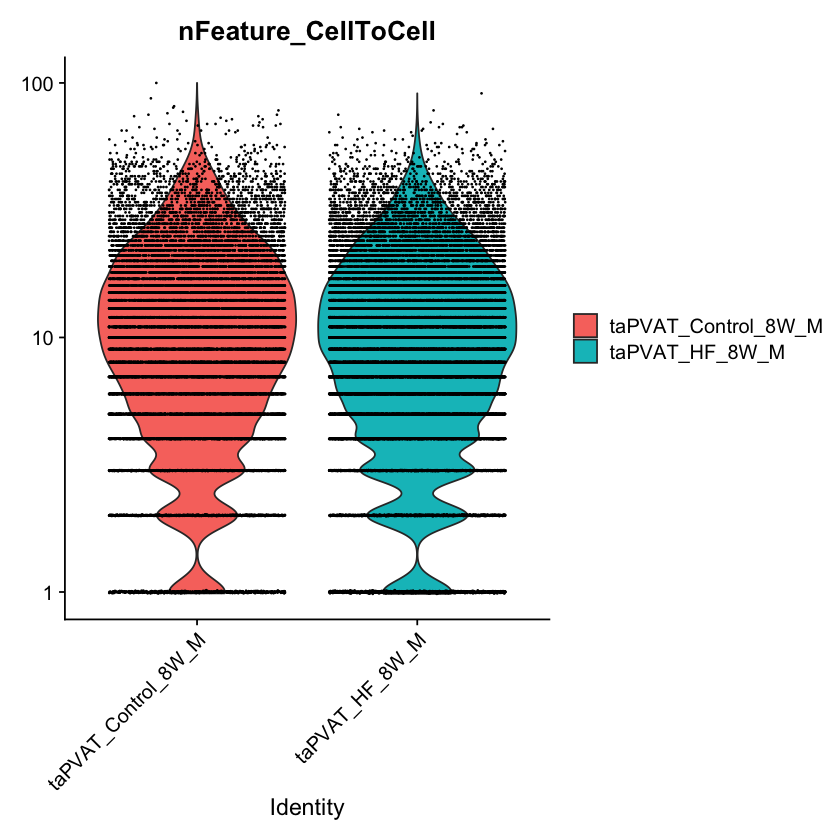

In [18]:
# Merge together
scc.merge <- merge(temp.list[[1]],temp.list[2])

# Clean up low-information crosses (connectivity data can be very sparse)
VlnPlot(scc.merge,features = 'nFeature_CellToCell',group.by = 'Condition',pt.size=0.1,log = T)

In [19]:
scc.sub <- subset(scc.merge,nFeature_CellToCell > 5) # Requesting at least 5 distinct ligand-receptor interactions between two cells

In [20]:
unique(scc.sub$VectorType)

[1] "Fibroblasts—Fibroblasts"             "Fibroblasts—Adipocytes"             
 [3] "Fibroblasts—Immune_Cells"            "Fibroblasts—Endothelial_Cells"      
 [5] "Fibroblasts—Pericytes"               "Fibroblasts—Mesothelial_Cells"      
 [7] "Fibroblasts—Neuronal_Cells"          "Fibroblasts—SMCs"                   
 [9] "Adipocytes—Fibroblasts"              "Adipocytes—Adipocytes"              
[11] "Adipocytes—Immune_Cells"             "Adipocytes—Endothelial_Cells"       
[13] "Adipocytes—Pericytes"                "Adipocytes—Mesothelial_Cells"       
[15] "Adipocytes—Neuronal_Cells"           "Adipocytes—SMCs"                    
[17] "Immune_Cells—Fibroblasts"            "Immune_Cells—Adipocytes"            
[19] "Immune_Cells—Immune_Cells"           "Immune_Cells—Endothelial_Cells"     
[21] "Immune_Cells—Pericytes"              "Immune_Cells—Mesothelial_Cells"     
[23] "Immune_Cells—Neuronal_Cells"         "Endothelial_Cells—Fibroblasts"      
[25] "Endothelial_Cells—Adipocytes"        "Endothelial_Cells—Immune_Cells"     
[27] "Endothelial_Cells—Endothelial_Cells" "Endothelial_Cells—Pericytes"        
[29] "Endothelial_Cells—Mesothelial_Cells" "Endothelial_Cells—Neuronal_Cells"   
[31] "Endothelial_Cells—SMCs"              "Pericytes—Fibroblasts"              
[33] "Pericytes—Adipocytes"                "Pericytes—Immune_Cells"             
[35] "Pericytes—Endothelial_Cells"         "Pericytes—Pericytes"                
[37] "Pericytes—Mesothelial_Cells"         "Pericytes—Neuronal_Cells"           
[39] "Pericytes—SMCs"                      "Mesothelial_Cells—Fibroblasts"      
[41] "Mesothelial_Cells—Adipocytes"        "Mesothelial_Cells—Immune_Cells"     
[43] "Mesothelial_Cells—Endothelial_Cells" "Mesothelial_Cells—Pericytes"        
[45] "Mesothelial_Cells—Mesothelial_Cells" "Mesothelial_Cells—Neuronal_Cells"   
[47] "Mesothelial_Cells—SMCs"              "Neuronal_Cells—Fibroblasts"         
[49] "Neuronal_Cells—Adipocytes"           "Neuronal_Cells—Endothelial_Cells"   
[51] "Neuronal_Cells—Pericytes"            "Neuronal_Cells—Mesothelial_Cells"   
[53] "Neuronal_Cells—Neuronal_Cells"       "Neuronal_Cells—SMCs"                
[55] "SMCs—Fibroblasts"                    "SMCs—Adipocytes"                    
[57] "SMCs—Immune_Cells"                   "SMCs—Endothelial_Cells"             
[59] "SMCs—Pericytes"                      "SMCs—Mesothelial_Cells"             
[61] "SMCs—Neuronal_Cells"                 "SMCs—SMCs"                          
[63] "Immune_Cells—SMCs"                   "Neuronal_Cells—Immune_Cells"

In [21]:
#as.data.frame(GetAssayData(scc.list$taPVAT_Control_8W_M$CellToCell, slot = "counts"))

In [22]:
df <- as.data.frame(GetAssayData(scc.list$taPVAT_Control_8W_M$CellToCell, slot = "counts"))

In [23]:
tail(df)

CCTCCAACACTGTGTA-1-2—TGGAACTGTAGATTAG-1-1
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           CATGCAATCGAAACAA-1-0—GTTCGCTGTCGTTGCG-1-0
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           GCTACAAGTCTAACTG-1-1—GGGAAGTTCCGTCAAA-1-0
Wnt5a—Fzd8 0.000000                                 
Wnt5a—Lrp5 0.000000                                 
Wnt5a—Mcam 0.000000                                 
Wnt5a—Ror1 7.213621                                 
Wnt5a—Ror2 0.000000                                 
Wnt5a—Ryk  0.000000                                 
           CTACGGGAGACCCGCT-1-1—TGACGCGCAGCCGGTT-1-1
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           TATTTCGTCACCATCC-1-0—GAACACTAGCGGATCA-1-1
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           GTTACAGGTTGCTGAT-1-0—ATAGAGAGTAGAATAC-1-0
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           CTTACCGGTACTGTTG-1-0—AGAACAAAGAGGCTGT-1-0
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           TCATTGTTCTCCGAGG-1-0—GTTCATTCACATTCGA-1-1
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           TGGGAGACATAGAGGC-1-1—CATGCAATCGAAACAA-1-0
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0                                        
Wnt5a—Ryk  0                                        
           TAACGACTCCGCACTT-1-0—CAGATTGTCTGTGCAA-1-2 ⋯
Wnt5a—Fzd8 0                                         ⋯
Wnt5a—Lrp5 0                                         ⋯
Wnt5a—Mcam 0                                         ⋯
Wnt5a—Ror1 0                                         ⋯
Wnt5a—Ror2 0                                         ⋯
Wnt5a—Ryk  0                                         ⋯
           GCAGTTAAGGAACGTC-1-0—ATCGTAGAGGGTATAT-1-0
Wnt5a—Fzd8 0                                        
Wnt5a—Lrp5 0                                        
Wnt5a—Mcam 0                                        
Wnt5a—Ror1 0                                        
Wnt5a—Ror2 0          

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Vegfa—Nrp1, Sorbs1—Insr, Sorbs1—Itga1, Nrg4—Erbb4, Gnas—Adrb3, Adipoq—Adipor2, Lpl—Lrp1, Fgf1—Nrp1, Psap—Lrp1, Gnas—Adcy9 
	   Sorbs1—Itgb5, Vegfa—Itgav, Fgf1—Fgfr1, Vegfa—Nrp2, Nampt—Insr, Nrg4—Egfr, Vegfb—Nrp1, Psap—Sort1, Gnas—Adora1, Calm1—Insr 
	   Calm1—Mylk, Adam17—Erbb4, Gnas—Tshr, Uba52—Tgfbr2, Adipoq—Adipor1, Lpl—Vldlr, Uba52—Acvr1, Ltbp3—Itgb5, Farp2—Plxna2, Vegfa—Sirpa 
Negative:  Lama2—Itgb1, Col3a1—Itgb1, Col6a2—Itgb1, Col5a2—Itgb1, Col6a3—Itgb1, Col6a1—Itgb1, Fbn1—Itgb1, Col1a2—Itgb1, Col5a1—Itgb1, Col1a1—Itgb1 
	   Adam12—Itgb1, Col4a4—Itgb1, Lamc1—Itgb1, Col4a1—Itgb1, Lama2—Itga1, Hspg2—Itgb1, Lama4—Itgb1, Col4a3—Itgb1, Col6a2—Itga1, Col5a2—Itga1 
	   Nid1—Itgb1, Col6a3—Itga1, Col6a1—Itga1, Col1a2—Itga1, Col4a5—Itgb1, Angpt1—Itgb1, Col1a1—Itga1, Fn1—Itgb1, Vegfc—Itgb1, Col4a4—Itga1 
PC_ 2 
Positive:  Lama4—Itgb1, Col4a1—Itgb1, Veg

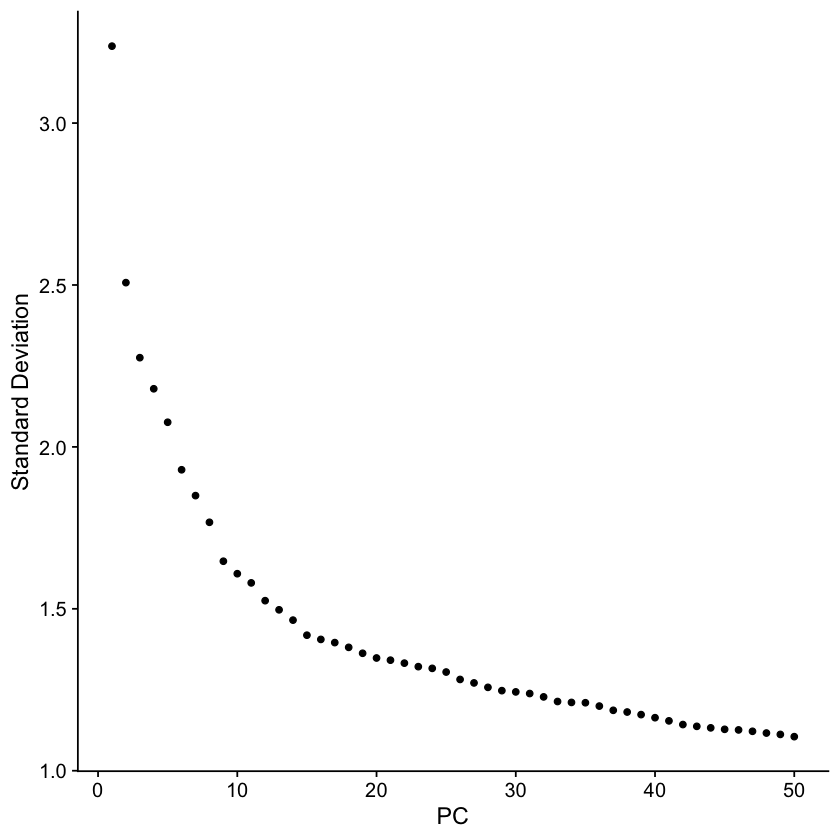

In [24]:
# Perform initial visualization
scc.sub <- ScaleData(scc.sub)
scc.sub <- FindVariableFeatures(scc.sub,selection.method = "disp")
scc.sub <- RunPCA(scc.sub,npcs = 50)
ElbowPlot(scc.sub,ndim=50)

18:47:17 UMAP embedding parameters a = 0.9922 b = 1.112

18:47:17 Read 26914 rows and found 25 numeric columns

18:47:17 Using Annoy for neighbor search, n_neighbors = 30

18:47:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:47:20 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpxeeiJe/file235e16ad4921

18:47:20 Searching Annoy index using 1 thread, search_k = 3000

18:47:27 Annoy recall = 100%

18:47:28 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:47:29 Initializing from normalized Laplacian + noise (using RSpectra)

18:47:29 Commencing optimization for 200 epochs, with 1171974 positive edges

18:47:54 Optimization finished



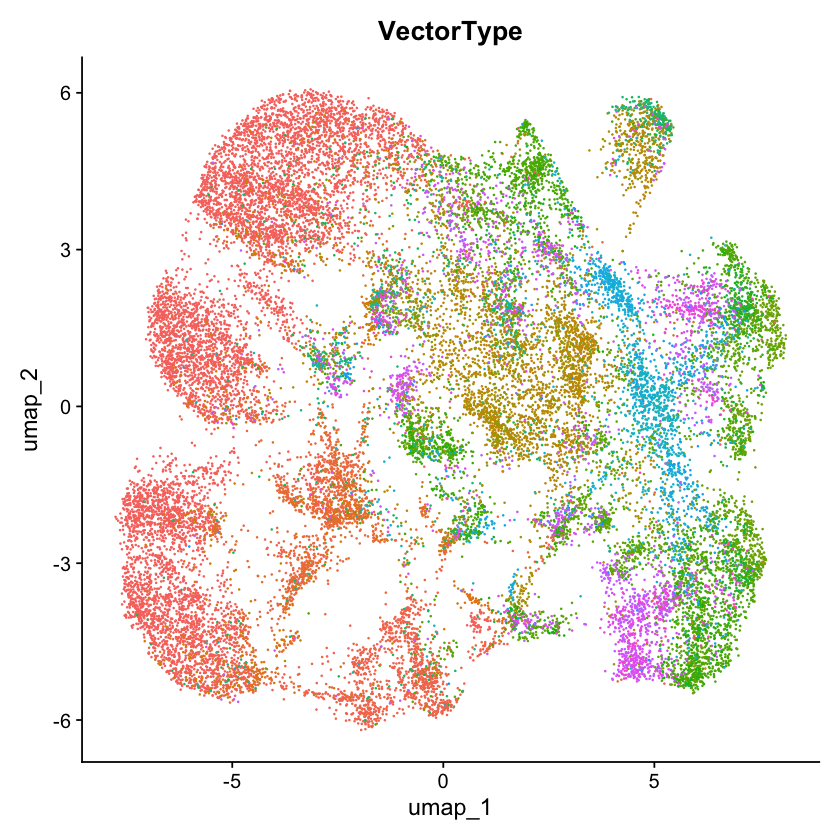

In [25]:
scc.sub <- RunUMAP(scc.sub,dims = 1:25)
DimPlot(scc.sub,group.by = 'VectorType')+NoLegend()

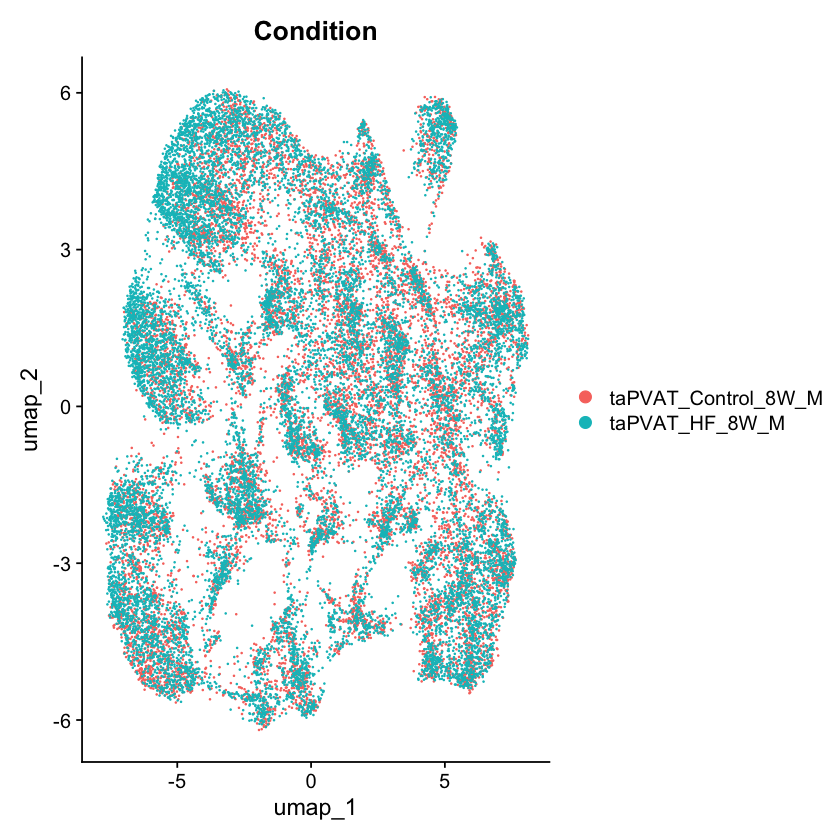

In [26]:
DimPlot(scc.sub,group.by = 'Condition')

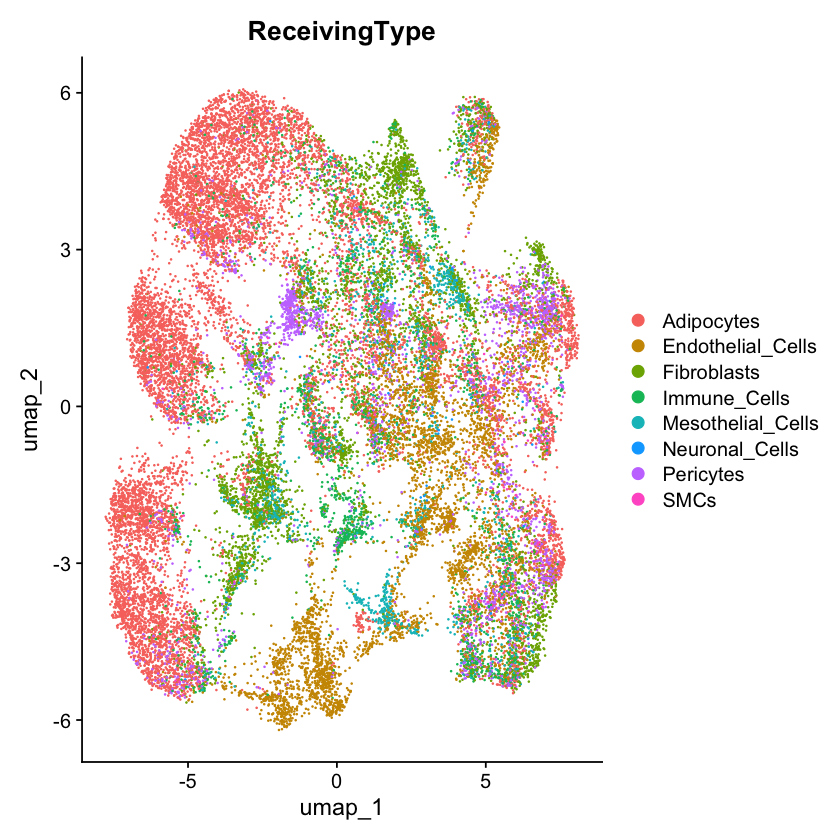

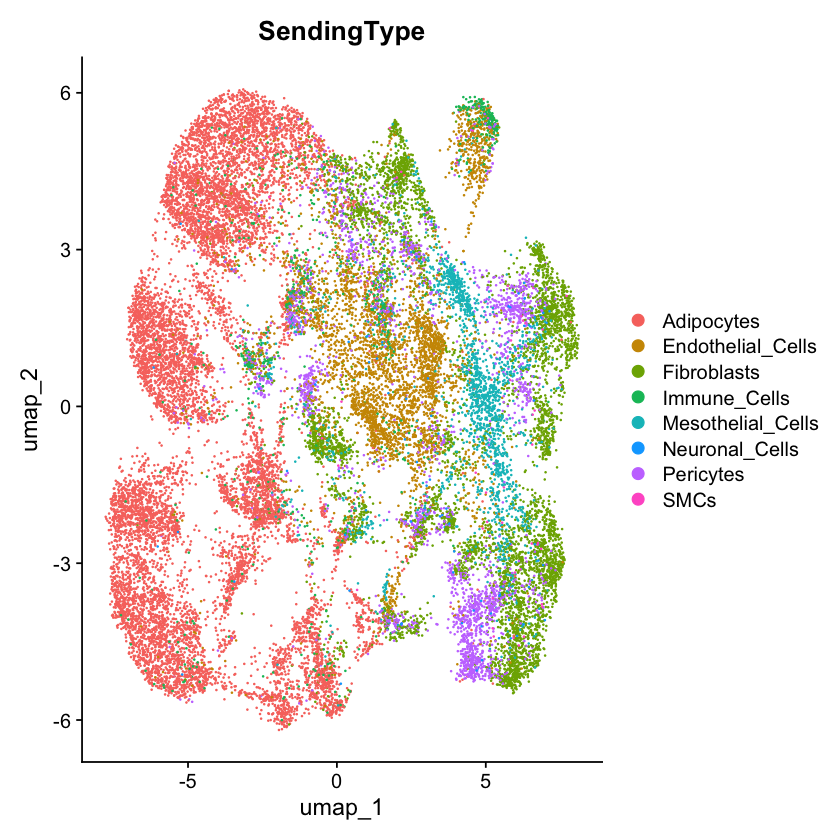

In [27]:
DimPlot(scc.sub,group.by = 'ReceivingType')
DimPlot(scc.sub,group.by = 'SendingType')

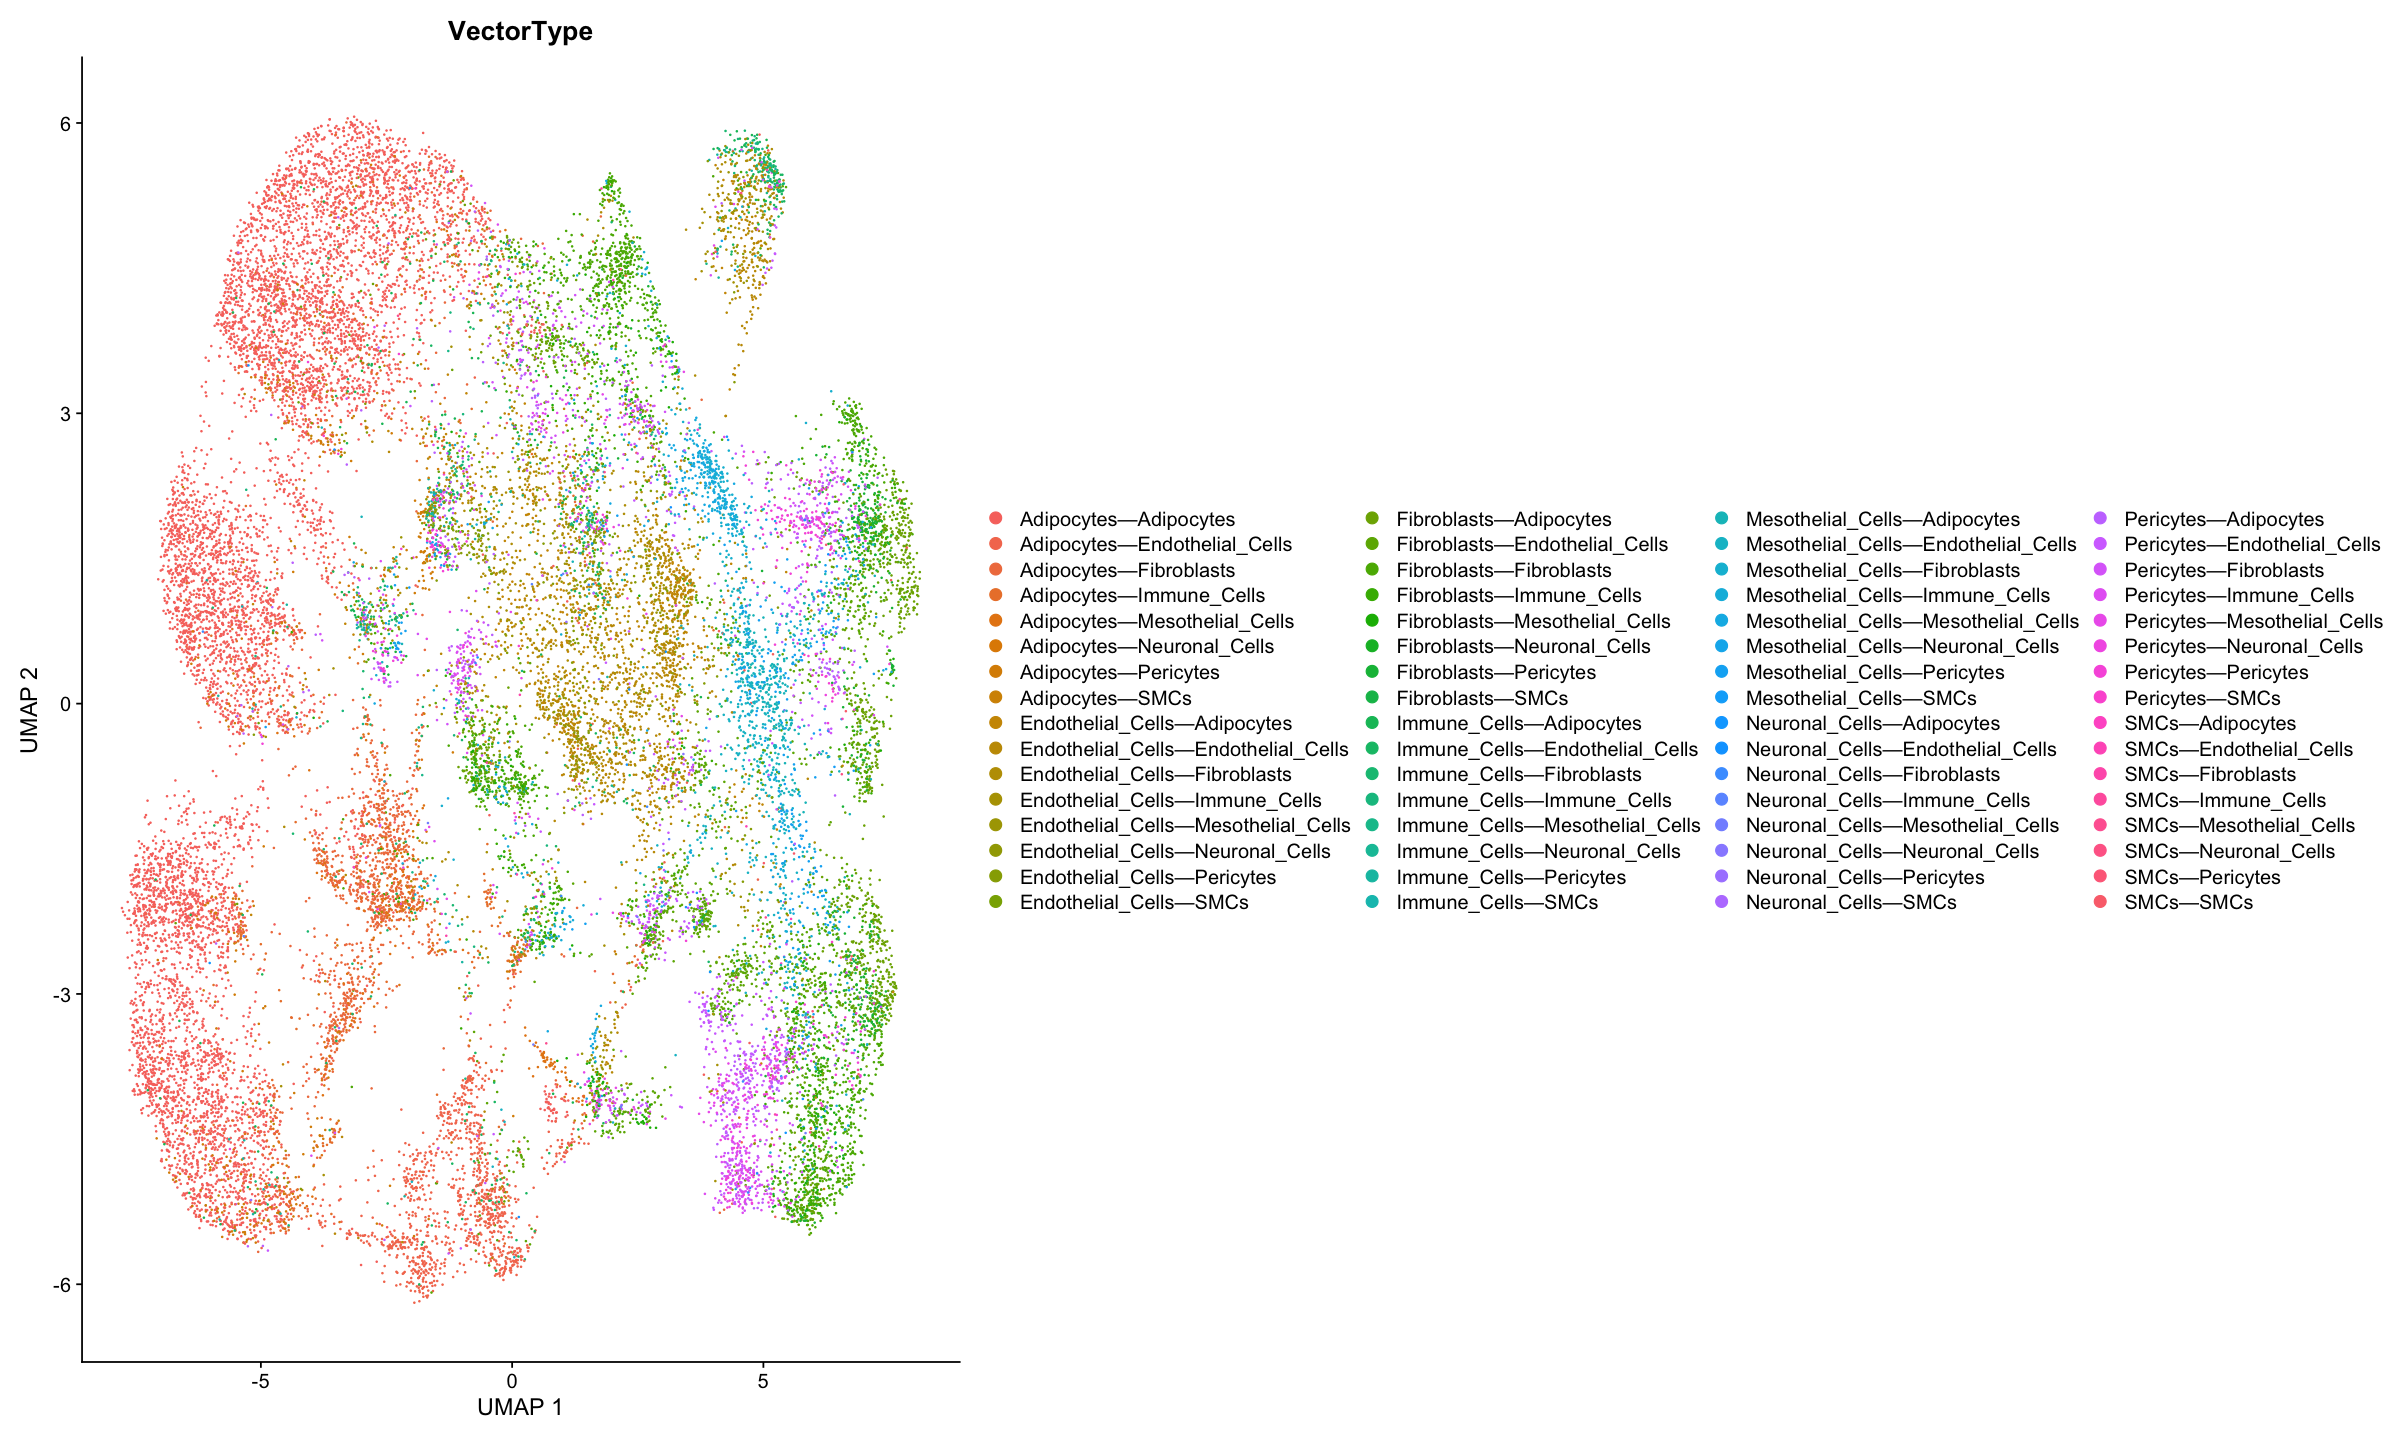

In [28]:
options(repr.plot.width=20, repr.plot.height=12)
DimPlot(scc.sub,group.by = 'VectorType') + labs(x = "UMAP 1", y = "UMAP 2")

In [29]:
scc.sub@meta.data

orig.ident    nCount_CellToCell
CCTCCAACACTGTGTA-1-2—TGGAACTGTAGATTAG-1-1 SeuratProject  81.87128        
CATGCAATCGAAACAA-1-0—GTTCGCTGTCGTTGCG-1-0 SeuratProject  86.88487        
GCTACAAGTCTAACTG-1-1—GGGAAGTTCCGTCAAA-1-0 SeuratProject  93.60927        
CTACGGGAGACCCGCT-1-1—TGACGCGCAGCCGGTT-1-1 SeuratProject 154.49311        
TATTTCGTCACCATCC-1-0—GAACACTAGCGGATCA-1-1 SeuratProject  55.32962        
CTTACCGGTACTGTTG-1-0—AGAACAAAGAGGCTGT-1-0 SeuratProject 149.72980        
TCATTGTTCTCCGAGG-1-0—GTTCATTCACATTCGA-1-1 SeuratProject  48.84418        
TGGGAGACATAGAGGC-1-1—CATGCAATCGAAACAA-1-0 SeuratProject  83.95150        
TAACGACTCCGCACTT-1-0—CAGATTGTCTGTGCAA-1-2 SeuratProject  99.48029        
GAGTCTACAACTGGTT-1-1—TAACGACTCCGCACTT-1-0 SeuratProject  68.47279        
TGTTCTAAGTGCCAGA-1-2—GAGTGTTTCCTGTAGA-1-1 SeuratProject  81.00391        
TGCTCGTAGTGATAAC-1-1—GTACAGTCACCGGAAA-1-1 SeuratProject 106.72537        
GTAGGAGAGTCTCGTA-1-2—ATGGGAGTCATGCCCT-1-0 SeuratProject  81.82815        
ACGGTTACAAAGCACG-1-0—TTGTTCAGTAGAGATT-1-0 SeuratProject  94.81057        
GTGAGCCAGATAACGT-1-2—TCTCCGAGTGGGACAT-1-0 SeuratProject  52.37020        
CTTTCGGGTCACGACC-1-1—CACATGACATATAGCC-1-2 SeuratProject 104.40123        
CCGTGAGGTGCCTGCA-1-2—TACATTCTCGCCATAA-1-0 SeuratProject  88.27659        
TTTGATCAGCGTTCAT-1-0—AGAAATGTCTGCGAGC-1-1 SeuratProject 226.25748        
TTACGCCAGGTAATCA-1-1—GAACGTTTCCCAGGCA-1-0 SeuratProject 177.60843        
TGTTGGAGTCACAGAG-1-2—ATGGGAGAGGACAGCT-1-0 SeuratProject 142.21401        
TATCTGTAGTAACCGG-1-1—GTTGTGATCTAGGAAA-1-2 SeuratProject  63.81274        
AGTTCGACAATAGAGT-1-1—TTAGGGTTCACGGTCG-1-1 SeuratProject  86.31696        
CACCAAACATGACGGA-1-0—AGGGTTTCAAAGGGTC-1-0 SeuratProject  98.89928        
ACGTAACCACCCGTAG-1-1—TACCGGGAGGACAACC-1-0 SeuratProject 225.84331        
GTCGAATTCGAACGCC-1-1—TCGTCCACATGCTGCG-1-0 SeuratProject  96.07957        
GCGAGAATCCGATGTA-1-1—ATGGGTTGTTAAACCC-1-0 SeuratProject  53.66043        
TATTCCAGTAGCACAG-1-1—ACATCCCGTAGACGTG-1-1 SeuratProject 105.29928        
TGCGGGTTCAGTGATC-1-0—TCAATCTTCCGGCTTT-1-2 SeuratProject 108.39061        
TCTTGCGTCTGTTCAT-1-1—ATCGTAGCACCGTGGT-1-2 SeuratProject  47.68286        
CGTGTCTCAAAGGCAC-1-2—AAAGGTATCAGACCGC-1-1 SeuratProject  69.46341        
⋮                                         ⋮             ⋮                
AGACAGGGTGCAGTGA-1-4—TGTTGGAGTACAAGCG-1-3 SeuratProject  48.00310        
GATGAGGGTTCCTAGA-1-3—CAGATCACATCGGAGA-1-4 SeuratProject 131.78336        
AGTAGCTAGACTACGG-1-5—AGCGTATCATGAGATA-1-3 SeuratProject  92.81703        
TTGGGCGCAGCTACAT-1-4—TGGAGGATCTCAGGCG-1-5 SeuratProject  41.45946        
TACCGGGGTCGATTCA-1-4—TTCTTCCGTTAAAGTG-1-4 SeuratProject  37.37745        
ATCATTCCAAAGTGTA-1-4—GTTCATTCAGAATCGG-1-4 SeuratProject  48.08636        
CTGTGGGCACCTCAGG-1-5—TGTCCCACACTGAGGA-1-5 SeuratProject  76.15363        
ATGAGGGAGGCCTTGC-1-5—ACTATGGGTGTCATCA-1-5 SeuratProject  77.08895        
TTGGGCGCAGCTACAT-1-4—TCCCAGTAGTTATGGA-1-5 SeuratProject  82.56488        
TTCCGGTGTCGCGTCA-1-3—CTCACTGCACATCCCT-1-5 SeuratProject  90.48072        
GTAATGCTCCTGTAAG-1-4—ATGGTTGCAACGTATC-1-5 SeuratProject  66.62053        
ATCATTCCAAAGTGTA-1-4—TTAGGCAAGCACCGTC-1-3 SeuratProject  42.08652        
AGACAGGGTGCAGTGA-1-4—CAATACGAGTTTCAGC-1-4 SeuratProject  44.40449        
GGGTCTGAGCGTTACT-1-5—ATCCACCTCCGCGATG-1-5 SeuratProject  61.27798        
CGTGAATGTGTTGCCG-1-4—TATTCCATCAGGAAAT-1-4 SeuratProject  54.60215        
GATGAGGGTTCCTAGA-1-3—TTGCGTCCATTGGGAG-1-5 SeuratProject  92.46770        
TACCCACTCCGATGTA-1-5—ACTATTCTCGACGTCG-1-5 SeuratProject 151.84659        
AGTAGCTAGACTACGG-1-5—TCATTACTCATCTCTA-1-4 SeuratProject  72.22728        
CAATTTCGTTAGAAGT-1-4—TTCTGTATCCTGTAAG-1-5 SeuratProject  73.52302        
GTAATGCTCCTGTAAG-1-4—CTCCTCCCAAGTGCAG-1-5 SeuratProject  82.36910        
TTCCGGTGTCGCGTCA-1-3—CACGTTCGTAGATGTA-1-4 SeuratProject 120.28879        
CTGTGGGCACCTCAGG-1-5—CAGTTAGCAAGGACAC-1-5 SeuratProject  93.52061        
ATCATTCCAAAGTGTA-1-4—TGGCGTGCAGAACATA-1-5 Seur

In [30]:
table(scc.sub@meta.data$VectorType)


              Adipocytes—Adipocytes        Adipocytes—Endothelial_Cells 
                               7840                                1183 
             Adipocytes—Fibroblasts             Adipocytes—Immune_Cells 
                               1374                                 416 
       Adipocytes—Mesothelial_Cells           Adipocytes—Neuronal_Cells 
                                308                                  11 
               Adipocytes—Pericytes                     Adipocytes—SMCs 
                                475                                   9 
       Endothelial_Cells—Adipocytes Endothelial_Cells—Endothelial_Cells 
                               1001                                1040 
      Endothelial_Cells—Fibroblasts      Endothelial_Cells—Immune_Cells 
                                904                                 403 
Endothelial_Cells—Mesothelial_Cells    Endothelial_Cells—Neuronal_Cells 
                                260               

In [31]:
scc.sub@assays$CellToCell

Assay (v5) data with 853 features for 26914 cells
Top 10 variable features:
 Sema3a—Nrp1, Vegfa—Flt1, Lama2—Itga1, Col4a1—Itgb1, Vegfa—Nrp1,
Nxph1—Nrxn1, Vegfa—Egfr, Gnas—Tshr, Col3a1—Ddr2, Vegfa—Nrp2 
Layers:
 counts.1, counts.2, data.1, data.2, scale.data 

In [32]:
rownames(GetAssayData(scc.sub, assay = "CellToCell", slot = "scale.data"))

[1] "Adam10—Axl"        "Adam10—Epha3"      "Adam12—Itga9"     
  [4] "Adam12—Itgb1"      "Adam12—Sdc4"       "Adam15—Itga5"     
  [7] "Adam15—Itga9"      "Adam15—Itgav"      "Adam15—Itgb1"     
 [10] "Adam15—Itgb3"      "Adam17—Erbb4"      "Adam17—Itga5"     
 [13] "Adam17—Itgb1"      "Adam17—Notch1"     "Adam23—Itga5"     
 [16] "Adam23—Itgb3"      "Adam28—Itga4"      "Adam9—Itga3"      
 [19] "Adam9—Itga6"       "Adam9—Itgav"       "Adam9—Itgb1"      
 [22] "Adam9—Itgb5"       "Adipoq—Adipor1"    "Adipoq—Adipor2"   
 [25] "Adm—Calcrl"        "Angpt1—Itga5"      "Angpt1—Itgb1"     
 [28] "Angpt1—Tek"        "Angpt1—Tie1"       "Angpt2—Tek"       
 [31] "Angpt2—Tie1"       "Angpt4—Tek"        "Angpt4—Tie1"      
 [34] "Angptl1—Tek"       "Angptl2—Tie1"      "Angptl4—Tie1"     
 [37] "Anxa1—Dysf"        "Anxa1—Egfr"        "Apoe—Ldlr"        
 [40] "Apoe—Lrp1"         "Apoe—Lrp5"         "Apoe—Scarb1"      
 [43] "Apoe—Sorl1"        "Apoe—Vldlr"        "App—Cav1"         
 [46] "App—Cd74"          "App—Lrp1"          "App—Ncstn"        
 [49] "App—Slc45a3"       "App—Tnfrsf21"      "B2m—Cd247"        
 [52] "B2m—Tfrc"          "Bgn—Ly96"          "Bgn—Tlr4"         
 [55] "Bmp4—Acvr1"        "Bmp4—Acvr2a"       "Bmp4—Acvr2b"      
 [58] "Bmp4—Bmpr1a"       "Bmp4—Bmpr1b"       "Bmp4—Bmpr2"       
 [61] "Bmp5—Acvr1"        "Bmp5—Acvr2a"       "Bmp5—Acvr2b"      
 [64] "Bmp5—Bmpr1a"       "Bmp5—Bmpr1b"       "Bmp5—Bmpr2"       
 [67] "Bmp6—Acvr1"        "Bmp6—Acvr2a"       "Bmp6—Acvr2b"      
 [70] "Bmp6—Bmpr1a"       "Bmp6—Bmpr1b"       "Bmp6—Bmpr2"       
 [73] "C4b—Cd46"          "Calm1—Abca1"       "Calm1—Adcyap1r1"  
 [76] "Calm1—Cacna1c"     "Calm1—Egfr"        "Calm1—Fas"        
 [79] "Calm1—Glp2r"       "Calm1—Insr"        "Calm1—Kcnn4"      
 [82] "Calm1—Kcnq1"       "Calm1—Kcnq5"       "Calm1—Mylk"       
 [85] "Calm1—Pde1a"       "Calm1—Pde1b"       "Calm1—Pde1c"      
 [88] "Calm1—Ptpra"       "Calm1—Sctr"        "Calm1—Sell"       
 [91] "Calm1—Trpc3"       "Calm2—Abca1"       "Calm2—Egfr"       
 [94] "Calm2—Insr"        "Calm2—Kcnq1"       "Calm2—Kcnq5"      
 [97] "Calm2—Mylk"        "Calm2—Pde1a"       "Calm2—Pde1b"      
[100] "Calm2—Pde1c"       "Calm2—Sell"        "Calr—Itga3"       
[103] "Calr—Itgav"        "Calr—Lrp1"         "Calr—Scarf1"      
[106] "Calr—Tshr"         "Cd34—Sell"         "Cfh—Itgam"        
[109] "Cfh—Sell"          "Cgn—F11r"          "Cgn—Tgfbr1"       
[112] "Cgn—Tgfbr2"        "Clcf1—Cntfr"       "Clcf1—Crlf1"      
[115] "Clcf1—Il6st"       "Clcf1—Lifr"        "Cntf—Cntfr"       
[118] "Cntf—Il6st"        "Cntf—Lifr"         "Cntn4—Ptprg"      
[121] "Col14a1—Cd44"      "Col18a1—Gpc4"      "Col18a1—Itga5"    
[124] "Col18a1—Itgb1"     "Col18a1—Kdr"       "Col1a1—Cd44"      
[127] "Col1a1—Cd93"       "Col1a1—Ddr1"       "Col1a1—Ddr2"      
[130] "Col1a1—Flt4"       "Col1a1—Itga1"      "Col1a1—Itga11"    
[133] "Col1a1—Itga5"      "Col1a1—Itgav"      "Col1a1—Itgb1"     
[136] "Col1a2—Cd44"       "Col1a2—Cd93"       "Col1a2—Flt4"      
[139] "Col1a2—Itga1"      "Col1a2—Itga11"     "Col1a2—Itgav"     
[142] "Col1a2—Itgb1"      "Col1a2—Itgb3"      "Col3a1—Ddr1"      
[145] "Col3a1—Ddr2"       "Col3a1—Itgb1"      "Col4a1—Cd47"      
[148] "Col4a1—Cd93"       "Col4a1—Itga1"      "Col4a1—Itgav"     
[151] "Col4a1—Itgb1"      "Col4a1—Itgb8"      "Col4a2—Cd93"      
[154] "Col4a3—Cd47"       "Col4a3—Cd93"       "Col4a3—Itga1"     
[157] "Col4a3—Itgav"      "Col4a3—Itgb1"      "Col4a4—Cd47"      
[160] "Col4a4—Cd93"       "Col4a4—Itga1"      "Col4a4—Itgav"     
[163] "Col4a4—Itgb1"      "Col4a5—Cd47"       "Col4a5—Cd93"      
[166] "Col4a5—Itga1"      "Col4a5—Itgav"      "Col4a5—Itgb1"     
[169] "Col4a6—Cd47"       "Col4a6—Cd93"       "Col4a6—Itga1"     
[172] "Col4a6—Itgav"      "Col4a6—Itgb1"      "Col5a1—Itga1"     
[175] "Col5a1—Itgb1"      "Col5a1—Sdc3"       "Col5a2—Ddr1"      
[178] "Col5a2—Itga1"      "Col5a2—Itgb1"      "Col5a3—Sdc3"      
[181] "Col6a1—Itga1"      "Col6a1—Itga6"  

In [33]:
#x <- Fibroblasts—Adipocytes
#subs <- subset(scc.sub, subset = VectorType == x)

#print number of cells per condition
#print(paste0(x , ":  taPVAT_Control_8W_M:", sum(subs@meta.data$Condition == "taPVAT_Control_8W_M")))
#print(paste0(x , ":  taPVAT_HF_8W_M:", sum(subs@meta.data$Condition == "taPVAT_HF_8W_M")))

#set idents
#Idents(subs) <- subs@meta.data$Condition

#scale the subsetted data
#FindVariableFeatures(subs,assay='CellToCell',selection.method = "disp")
#ScaleData(subs, assay='CellToCell')

In [34]:

celltocell_heatmap <- function(VOI) {
    
results <- lapply(VOI, function(x){
 
  #subset
  subs <- subset(scc.sub, subset = VectorType == x)
  subs <- JoinLayers(subs, layers = c("data", "scale.data"))
  
  #print number of cells per condition
  print(paste0(x , ":  taPVAT_Control_8W_M:", sum(subs@meta.data$Condition == "taPVAT_Control_8W_M")))
  print(paste0(x , ":  taPVAT_HF_8W_M:", sum(subs@meta.data$Condition == "taPVAT_HF_8W_M")))
  
  #set idents
  Idents(subs) <- subs@meta.data$Condition
  
  #scale the subsetted data
  FindVariableFeatures(subs,assay='CellToCell',selection.method = "disp")
  ScaleData(subs, assay='CellToCell')
  
  #these are the features in the scaledata slot
  feats <- rownames(GetAssayData(subs, assay = "CellToCell", slot = "scale.data"))
  feats
  
  #find markers (here we use wilcox, but ROC and other tests can be used as well)




    
  markers <- FindAllMarkers(subs, features=feats, test.use = "wilcox",assay='CellToCell')
  top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
  markers_all <- markers %>% group_by(cluster)


    
  
  #subset to top 10 markers per condition
  
    
  list(subs = subs, top10 = top10, markers_all = markers_all)
  #Make a heatmap
  #plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top DE Mechanisms, CTRL vs STIM: ",x)
  
})

    return(results)

}

[1] "Fibroblasts—Adipocytes:  taPVAT_Control_8W_M:628"
[1] "Fibroblasts—Adipocytes:  taPVAT_HF_8W_M:888"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_8W_M

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster taPVAT_HF_8W_M



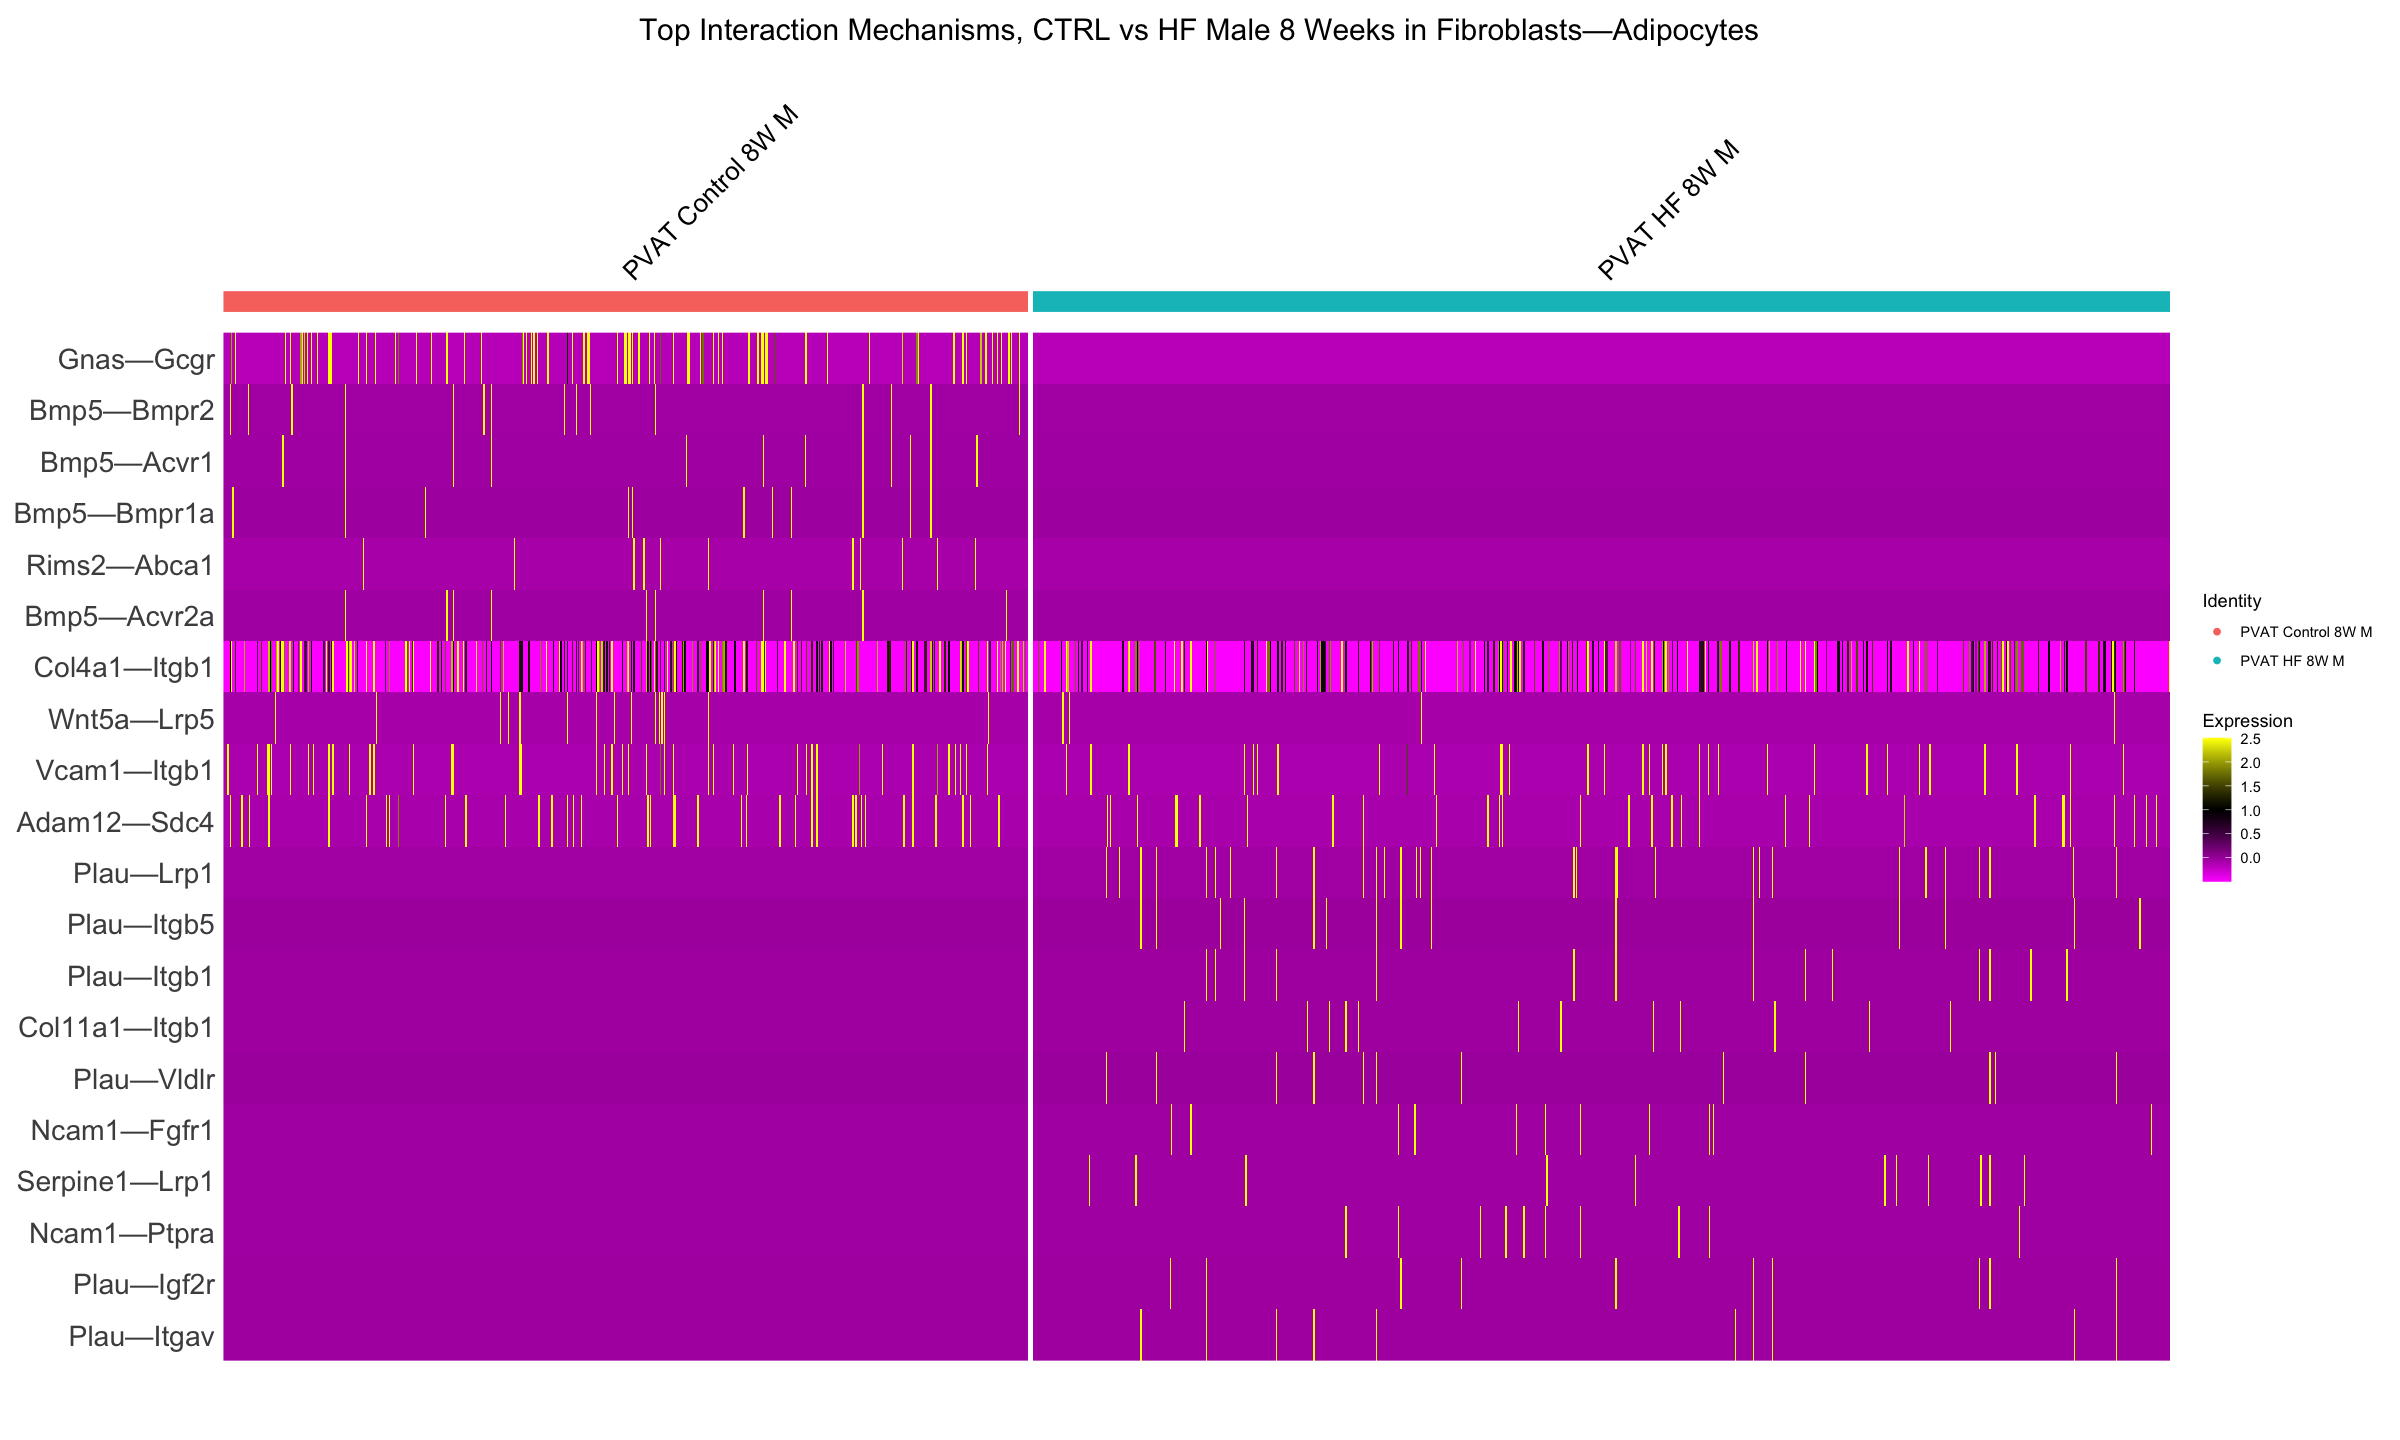

In [35]:
fibro_adipo <- celltocell_heatmap("Fibroblasts—Adipocytes")

options(repr.plot.width=20, repr.plot.height=12)
subs <- fibro_adipo[[1]]$subs
top10 <- fibro_adipo[[1]]$top10

Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_8W_M", "taPVAT_HF_8W_M"), 
                        labels = c("PVAT Control 8W M", "PVAT HF 8W M"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Male 8 Weeks in Fibroblasts—Adipocytes") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size =18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Male 8 Weeks in Fibroblasts—Adipocytes.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Fibroblasts:  taPVAT_Control_8W_M:589"
[1] "Adipocytes—Fibroblasts:  taPVAT_HF_8W_M:785"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_8W_M

Calculating cluster taPVAT_HF_8W_M



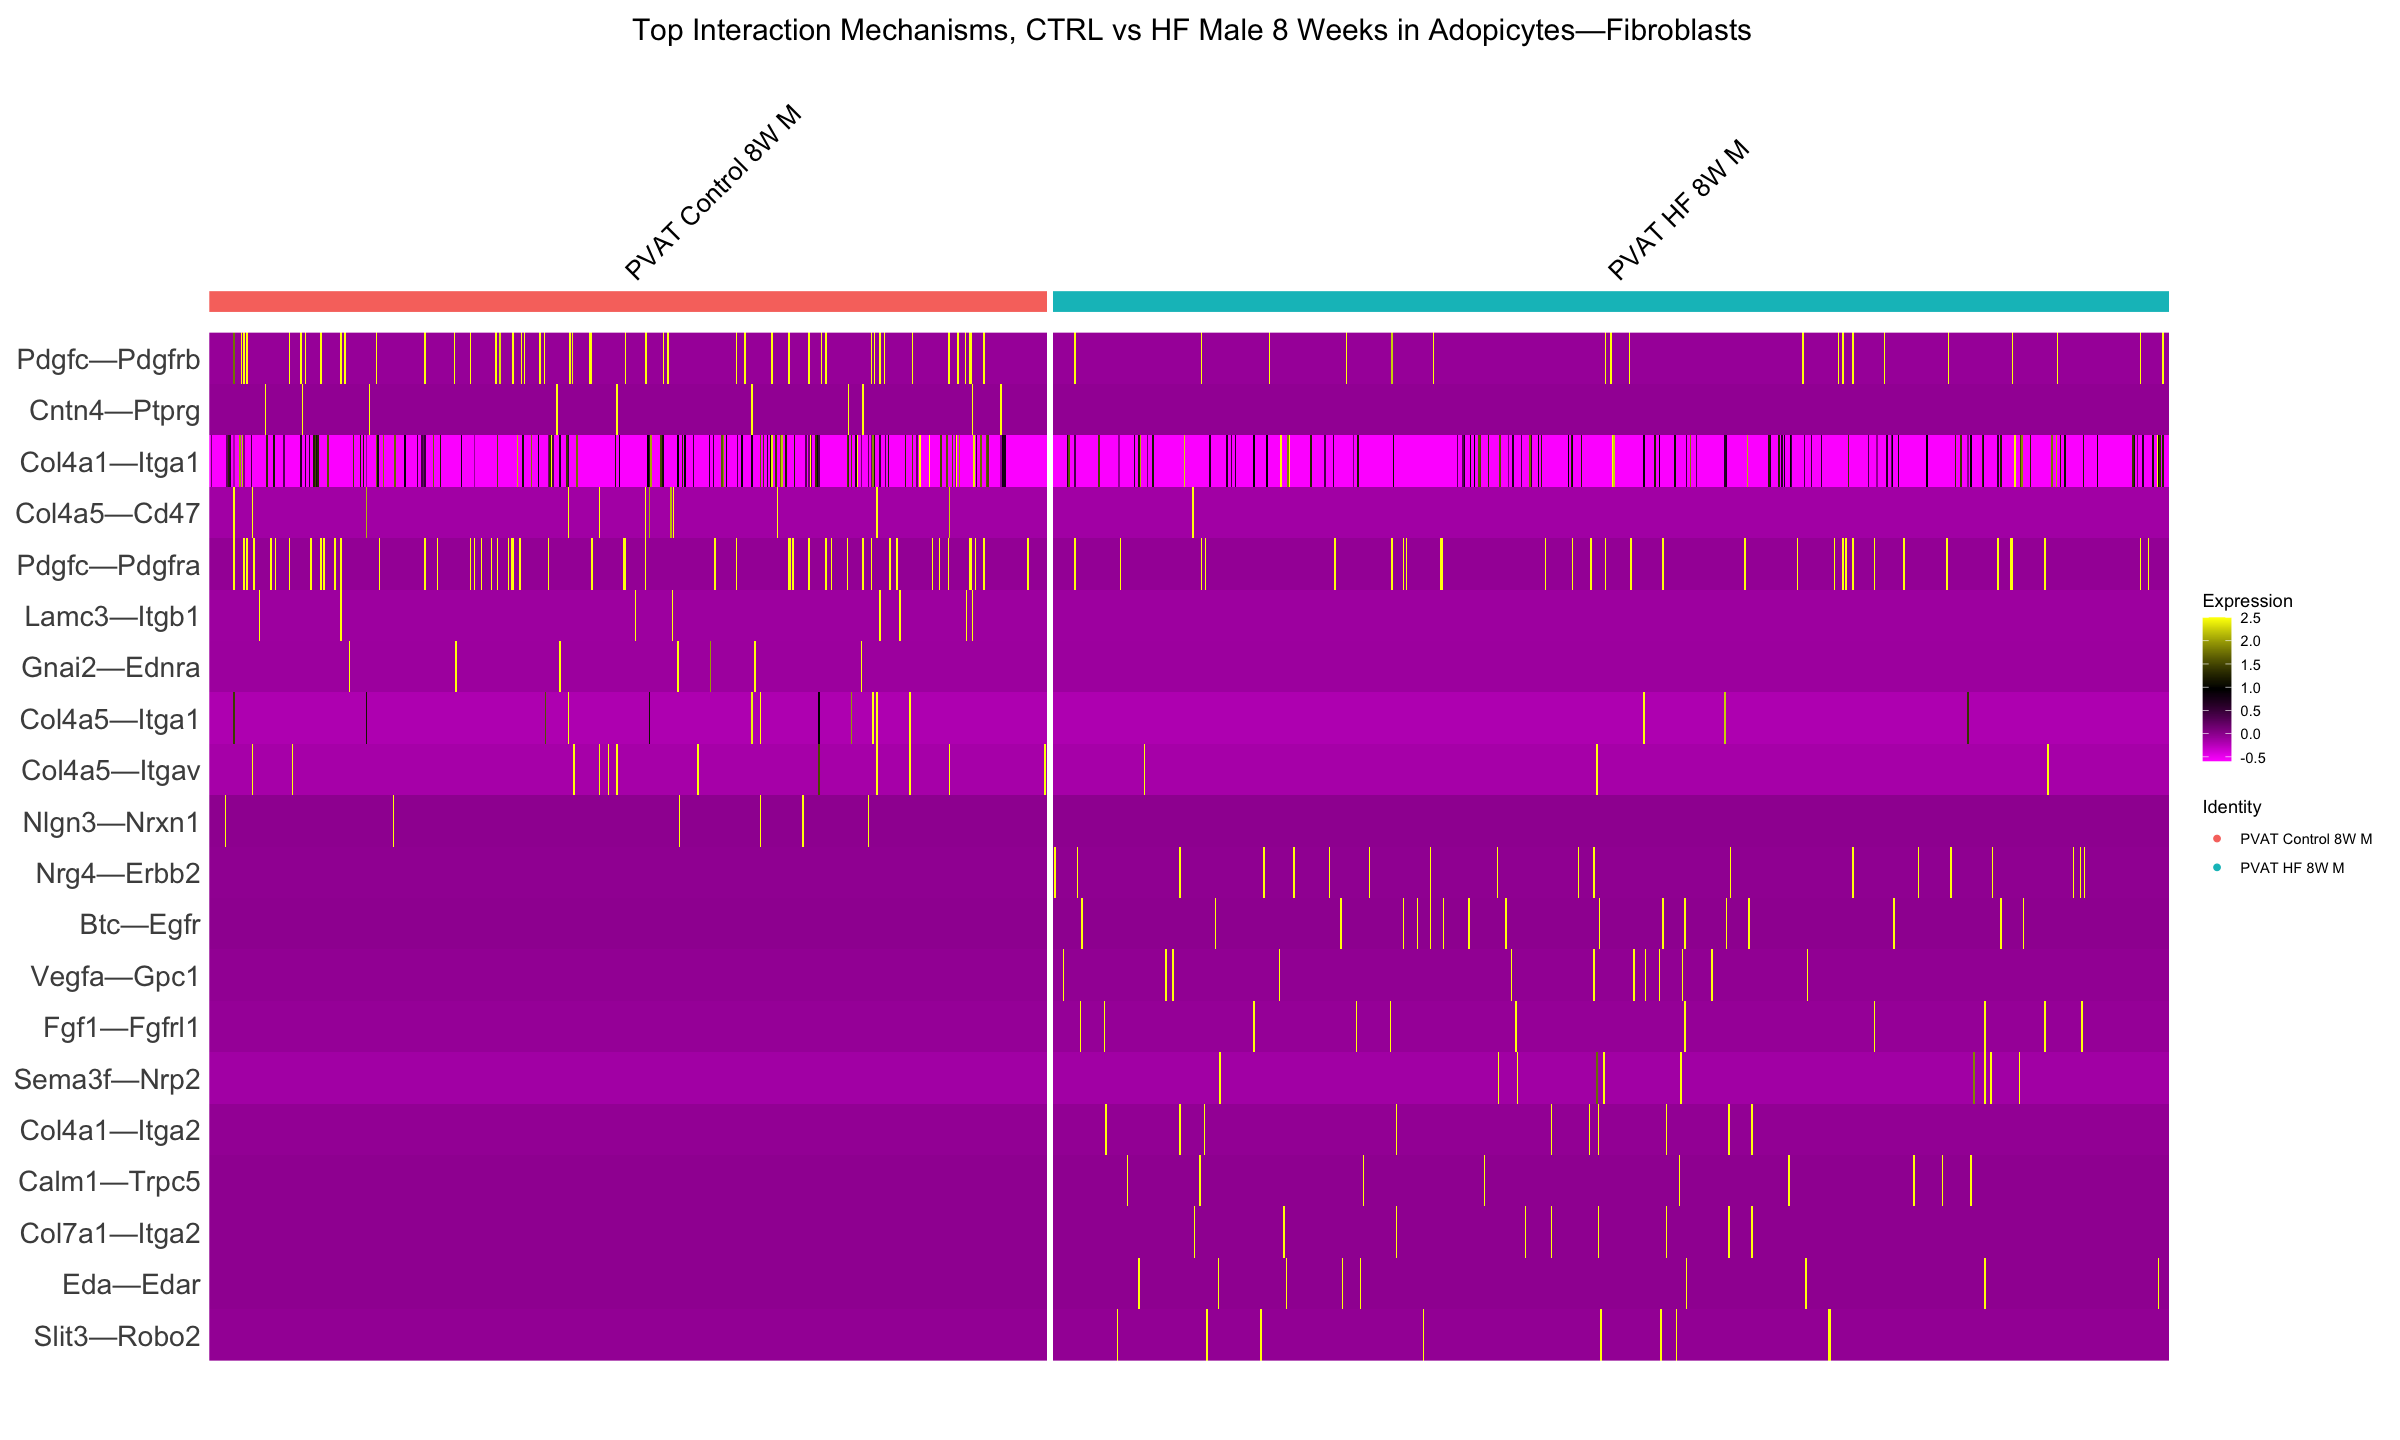

In [36]:
adipo_fibro <- celltocell_heatmap("Adipocytes—Fibroblasts")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_fibro[[1]]$subs
top10 <- adipo_fibro[[1]]$top10

Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_8W_M", "taPVAT_HF_8W_M"), 
                        labels = c("PVAT Control 8W M", "PVAT HF 8W M"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Male 8 Weeks in Adopicytes—Fibroblasts") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, , size =18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Male 8 Weeks in Adopicytes—Fibroblasts.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Endothelial_Cells:  taPVAT_Control_8W_M:496"
[1] "Adipocytes—Endothelial_Cells:  taPVAT_HF_8W_M:687"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_8W_M

Calculating cluster taPVAT_HF_8W_M



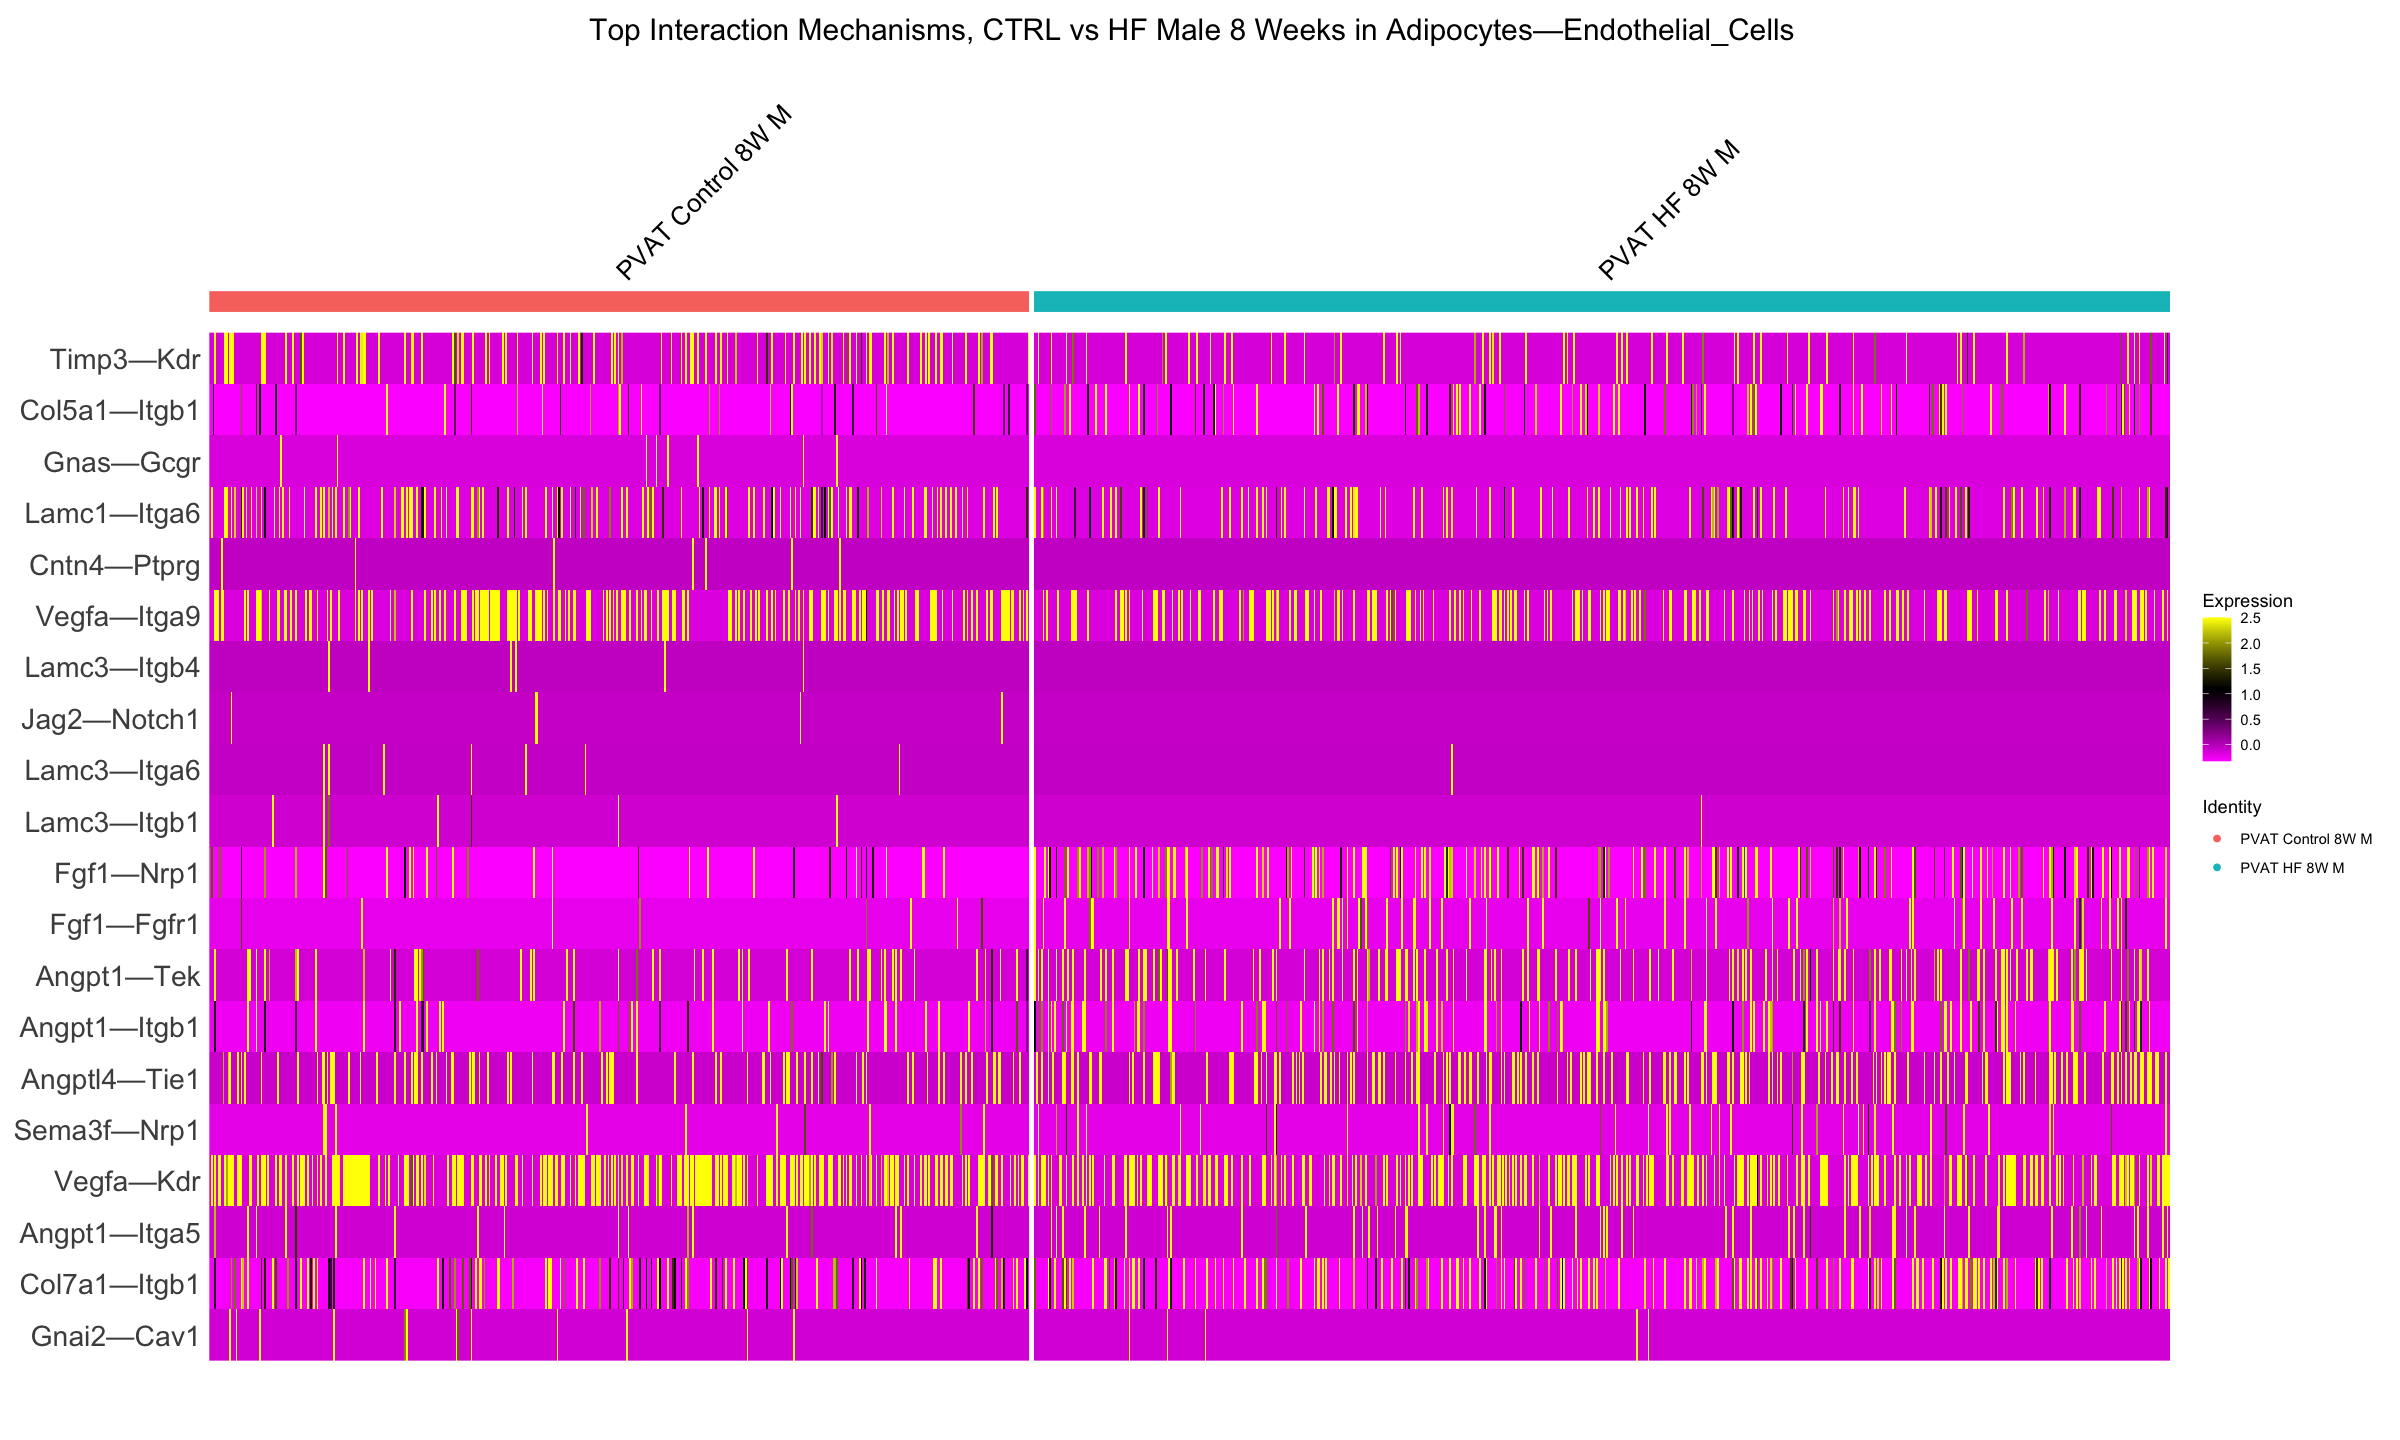

In [37]:
adipo_endo <- celltocell_heatmap("Adipocytes—Endothelial_Cells")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_endo[[1]]$subs
top10 <- adipo_endo[[1]]$top10
markers_all <- adipo_endo[[1]]$markers_all

Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_8W_M", "taPVAT_HF_8W_M"), 
                        labels = c("PVAT Control 8W M", "PVAT HF 8W M"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Male 8 Weeks in Adipocytes—Endothelial_Cells") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, , size =18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Male 8 Weeks in Adipocytes—Endothelial_Cells.pdf", plot = plot, width = 20, height = 12, dpi = 600)

In [38]:
markers_all

p_val        avg_log2FC  pct.1 pct.2 p_val_adj    cluster            
1  1.925112e-15  -2.9943388 0.067 0.240 1.642120e-12 taPVAT_Control_8W_M
2  1.589609e-08   0.5475598 0.200 0.087 1.355936e-05 taPVAT_Control_8W_M
3  2.389232e-08  -5.6690392 0.016 0.095 2.038015e-05 taPVAT_Control_8W_M
4  2.502151e-07  -1.1745278 0.071 0.169 2.134335e-04 taPVAT_Control_8W_M
5  6.484609e-07  -2.2331620 0.103 0.210 5.531371e-04 taPVAT_Control_8W_M
6  3.936183e-06  -0.8792769 0.069 0.157 3.357564e-03 taPVAT_Control_8W_M
7  9.895900e-06  -2.8444600 0.083 0.169 8.441202e-03 taPVAT_Control_8W_M
8  2.398061e-05  -1.1127293 0.302 0.198 2.045546e-02 taPVAT_Control_8W_M
9  3.358667e-05  -1.6994955 0.173 0.263 2.864943e-02 taPVAT_Control_8W_M
10 3.524198e-05   0.3574768 0.067 0.140 3.006141e-02 taPVAT_Control_8W_M
11 2.967815e-04  -1.3097918 0.020 0.066 2.531546e-01 taPVAT_Control_8W_M
12 3.705620e-04  -1.8724123 0.490 0.380 3.160894e-01 taPVAT_Control_8W_M
13 8.437514e-04  12.4269184 0.016 0.000 7.197199e-01 taPVAT_Control_8W_M
14 9.444799e-04  -3.4052560 0.038 0.086 8.056414e-01 taPVAT_Control_8W_M
15 1.764518e-03   0.8596075 0.248 0.172 1.000000e+00 taPVAT_Control_8W_M
16 1.802159e-03  10.5662086 0.014 0.000 1.000000e+00 taPVAT_Control_8W_M
17 2.315964e-03  -0.1485859 0.351 0.272 1.000000e+00 taPVAT_Control_8W_M
18 2.788735e-03  -2.2254707 0.210 0.263 1.000000e+00 taPVAT_Control_8W_M
19 3.874599e-03   6.7017124 0.012 0.000 1.000000e+00 taPVAT_Control_8W_M
20 8.406165e-03   7.8609287 0.010 0.000 1.000000e+00 taPVAT_Control_8W_M
21 8.761624e-03   6.0852954 0.014 0.001 1.000000e+00 taPVAT_Control_8W_M
22 8.761624e-03   4.6596448 0.014 0.001 1.000000e+00 taPVAT_Control_8W_M
23 8.846678e-03  -2.8352709 0.026 0.007 1.000000e+00 taPVAT_Control_8W_M
24 1.925112e-15   2.9943388 0.240 0.067 1.642120e-12 taPVAT_HF_8W_M     
25 1.589609e-08  -0.5475598 0.087 0.200 1.355936e-05 taPVAT_HF_8W_M     
26 2.389232e-08   5.6690392 0.095 0.016 2.038015e-05 taPVAT_HF_8W_M     
27 2.502151e-07   1.1745278 0.169 0.071 2.134335e-04 taPVAT_HF_8W_M     
28 6.484609e-07   2.2331620 0.210 0.103 5.531371e-04 taPVAT_HF_8W_M     
29 3.936183e-06   0.8792769 0.157 0.069 3.357564e-03 taPVAT_HF_8W_M     
30 9.895900e-06   2.8444600 0.169 0.083 8.441202e-03 taPVAT_HF_8W_M     
31 2.398061e-05   1.1127293 0.198 0.302 2.045546e-02 taPVAT_HF_8W_M     
32 3.358667e-05   1.6994955 0.263 0.173 2.864943e-02 taPVAT_HF_8W_M     
33 3.524198e-05  -0.3574768 0.140 0.067 3.006141e-02 taPVAT_HF_8W_M     
34 2.967815e-04   1.3097918 0.066 0.020 2.531546e-01 taPVAT_HF_8W_M     
35 3.705620e-04   1.8724123 0.380 0.490 3.160894e-01 taPVAT_HF_8W_M     
36 8.437514e-04 -12.4269184 0.000 0.016 7.197199e-01 taPVAT_HF_8W_M     
37 9.444799e-04   3.4052560 0.086 0.038 8.056414e-01 taPVAT_HF_8W_M     
38 1.764518e-03  -0.8596075 0.172 0.248 1.000000e+00 taPVAT_HF_8W_M     
39 1.802159e-03 -10.5662086 0.000 0.014 1.000000e+00 taPVAT_HF_8W_M     
40 2.315964e-03   0.1485859 0.272 0.351 1.000000e+00 taPVAT_HF_8W_M     
41 2.788735e-03   2.2254707 0.263 0.210 1.000000e+00 taPVAT_HF_8W_M     
42 3.874599e-03  -6.7017124 0.000 0.012 1.000000e+00 taPVAT_HF_8W_M     
43 8.406165e-03  -7.8609287 0.000 0.010 1.000000e+00 taPVAT_HF_8W_M     
44 8.761624e-03  -6.0852954 0.001 0.014 1.000000e+00 taPVAT_HF_8W_M     
45 8.761624e-03  -4.6596448 0.001 0.014 1.000000e+00 taPVAT_HF_8W_M     
46 8.846678e-03   2.8352709 0.007 0.026 1.000000e+00 taPVAT_HF_8W_M     
   gene        
1  Fgf1—Nrp1   
2  Timp3—Kdr   
3  Fgf1—Fgfr1  
4  Col5a1—Itga1
5  Angpt1—Tek  
6  Angpt1—Tie1 
7  Angpt1—Itgb1
8  Lamc1—Itga1 
9  Angptl4—Tie1
10 Col5a1—Itgb1
11 Sema3f—Nrp1 
12 Vegfa—Kdr   
13 Gnas—Gcgr   
14 Angpt1—Itga5
15 Lamc1—Itga6 
16 Cntn4—Ptprg 
17 Vegfa—Itga9 
18 Col7a1—Itgb1
19 Lamc3—Itgb4 
20 Jag2—Notch1 
21 Lamc3—Itga6 
22 Lamc3—Itgb1 
23 Gnai2—Cav1  
24 Fgf1—Nrp1   
25 Timp3—Kdr   
26 Fgf1—Fgfr1  
27 Col5a1—Itga1
28 Angpt1—Tek  
29 Angpt1—Tie1 
30 Angpt1—Itgb1
31 Lamc1—Itga1 
32 Angptl4—Tie1
33 Col5a1—Itgb1
34 Sema3f—Nrp1 
35 Vegfa—Kdr

In [39]:
VOI <- "Adipocytes—Endothelial_Cells"

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Vegfa—Nrp1, Lama4—Itgb1, Col4a1—Itgb1, Col7a1—Itgb1, Hspg2—Itgb1, Vegfb—Nrp1, Vegfb—Flt1, Fgf1—Nrp1, Lpl—Cd44, App—Cav1 
	   Sorbs1—Itga1, Adam17—Itgb1, Lpl—Gpihbp1, Adam9—Itgb1, Lamc1—Itga6, Col5a1—Itga1, Col4a1—Itga1, Pkm—Cd44, Fgf1—Cd44, Col4a2—Cd93 
	   Adam12—Itgb1, Vim—Cd44, Lamc1—Itga1, Lamb1—Itgb1, Col18a1—Kdr, Egf—Cav1, Adipoq—Adipor2, Col18a1—Itgb1, Psen1—Cd44, Fgf7—Nrp1 
Negative:  Vegfa—Itgav, Lama4—Itgav, Col4a1—Itgav, Lamc1—Itgav, Sorbs1—Insr, Calr—Itgav, Efna5—Ephb1, Efna5—Epha3, Farp2—Plxna4, Igf1—Insr 
	   Lamc1—Itgb4, Nampt—Insr, Calm1—Insr, Lama4—Itga3, Nid1—Itgav, Lamb1—Itgav, App—Slc45a3, Adipoq—Adipor1, Angpt1—Itga5, Rgma—Bmpr2 
	   Psap—Celsr1, Uba52—Tgfbr2, Adam17—Itga5, Col4a5—Itgav, Calr—Scarf1, Calm2—Insr, Lamc1—Itga3, Adam12—Itga9, Uba52—Notch1, Calr—Itga3 
PC_ 2 
Positive:  Vegfa—Nrp1, Col4a1—Itga1, Lpl—Cd44, Fgf1—Cd44

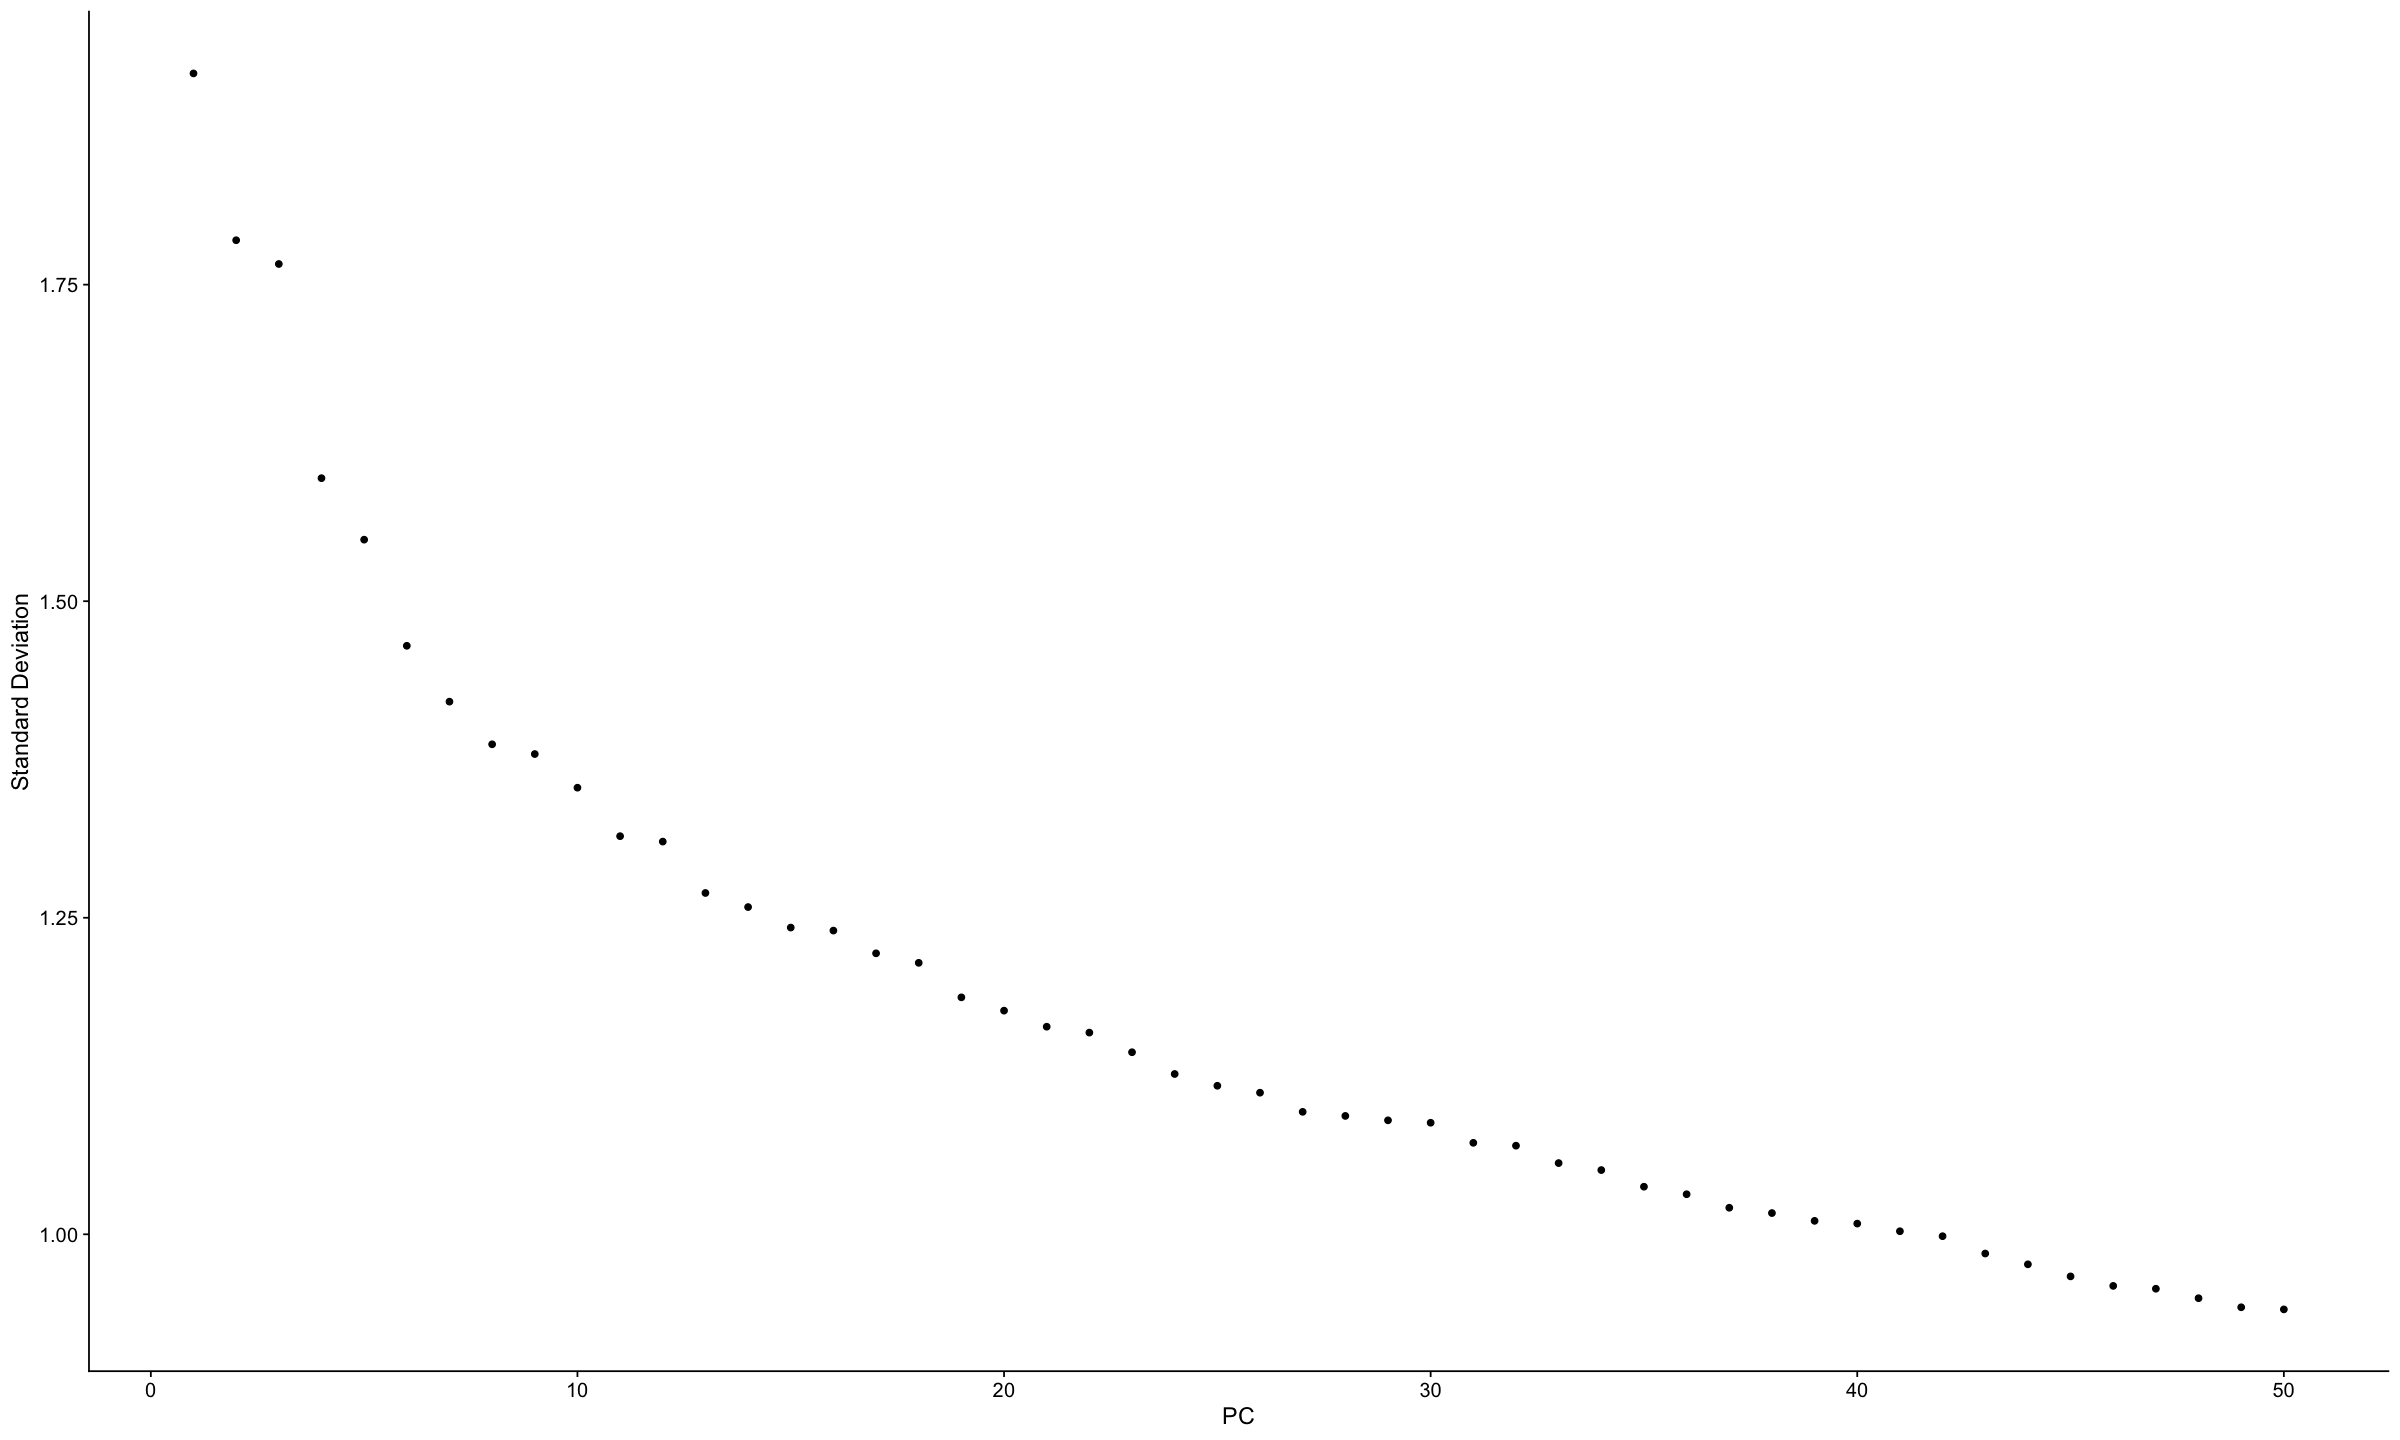

In [40]:
# Perform visualization for VectorTypes of interest
#VOI <- c("CD14 Mono—DC")
Idents(scc.sub) <- scc.sub@meta.data$VectorType
voi.data <- subset(scc.sub,idents = VOI)
voi.data <- ScaleData(voi.data)
voi.data <- FindVariableFeatures(voi.data,selection.method = "disp")
voi.data <- RunPCA(voi.data,npcs = 50)
ElbowPlot(voi.data,ndim=50)

18:48:09 UMAP embedding parameters a = 0.9922 b = 1.112

18:48:09 Read 1183 rows and found 10 numeric columns

18:48:09 Using Annoy for neighbor search, n_neighbors = 30

18:48:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:48:09 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpxeeiJe/file235e63bd4dcb

18:48:09 Searching Annoy index using 1 thread, search_k = 3000

18:48:09 Annoy recall = 100%

18:48:10 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:48:10 Initializing from normalized Laplacian + noise (using RSpectra)

18:48:10 Commencing optimization for 500 epochs, with 44434 positive edges

18:48:13 Optimization finished



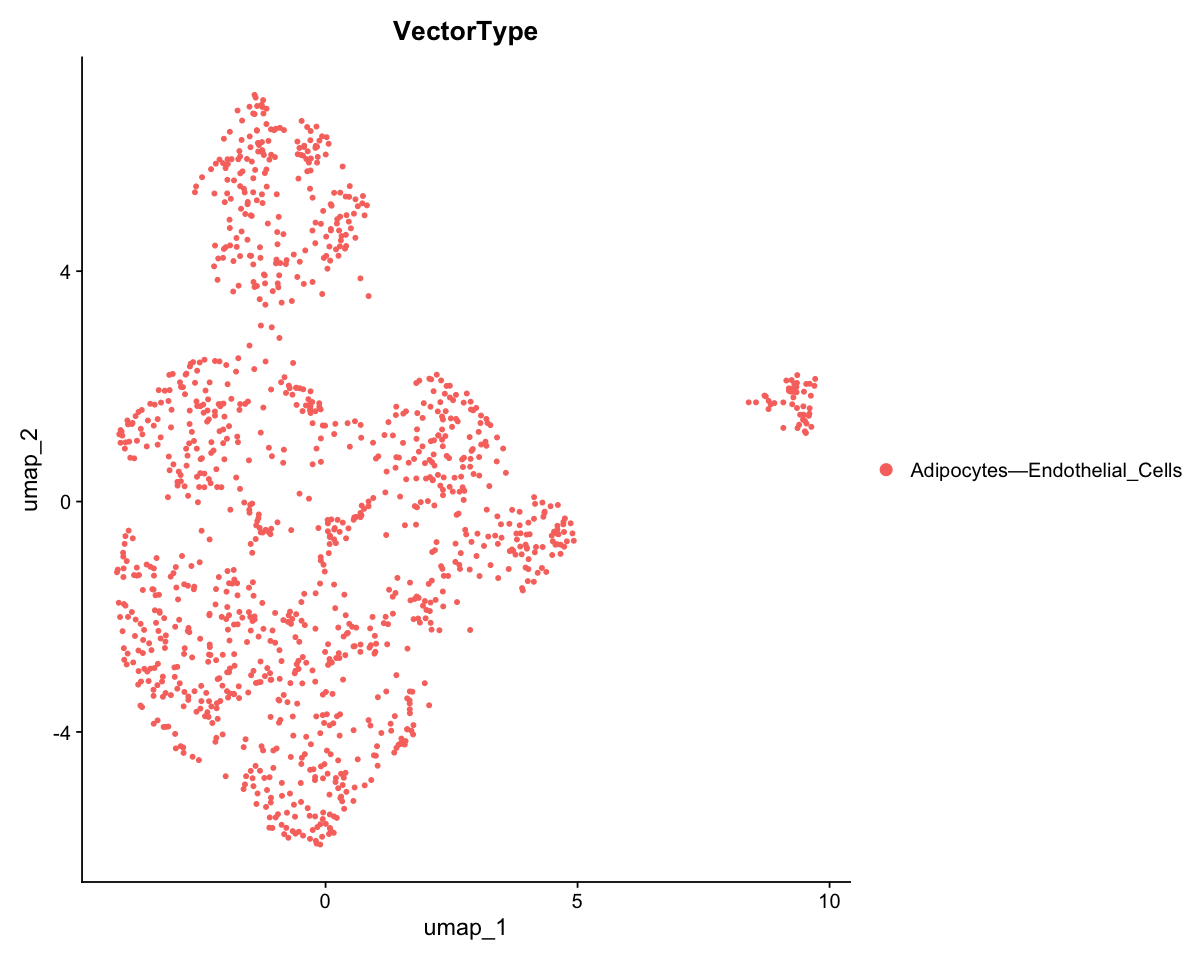

In [41]:
options(repr.plot.width=10, repr.plot.height=8)
voi.data <- RunUMAP(voi.data,dims = 1:10)
DimPlot(voi.data,group.by = 'VectorType')

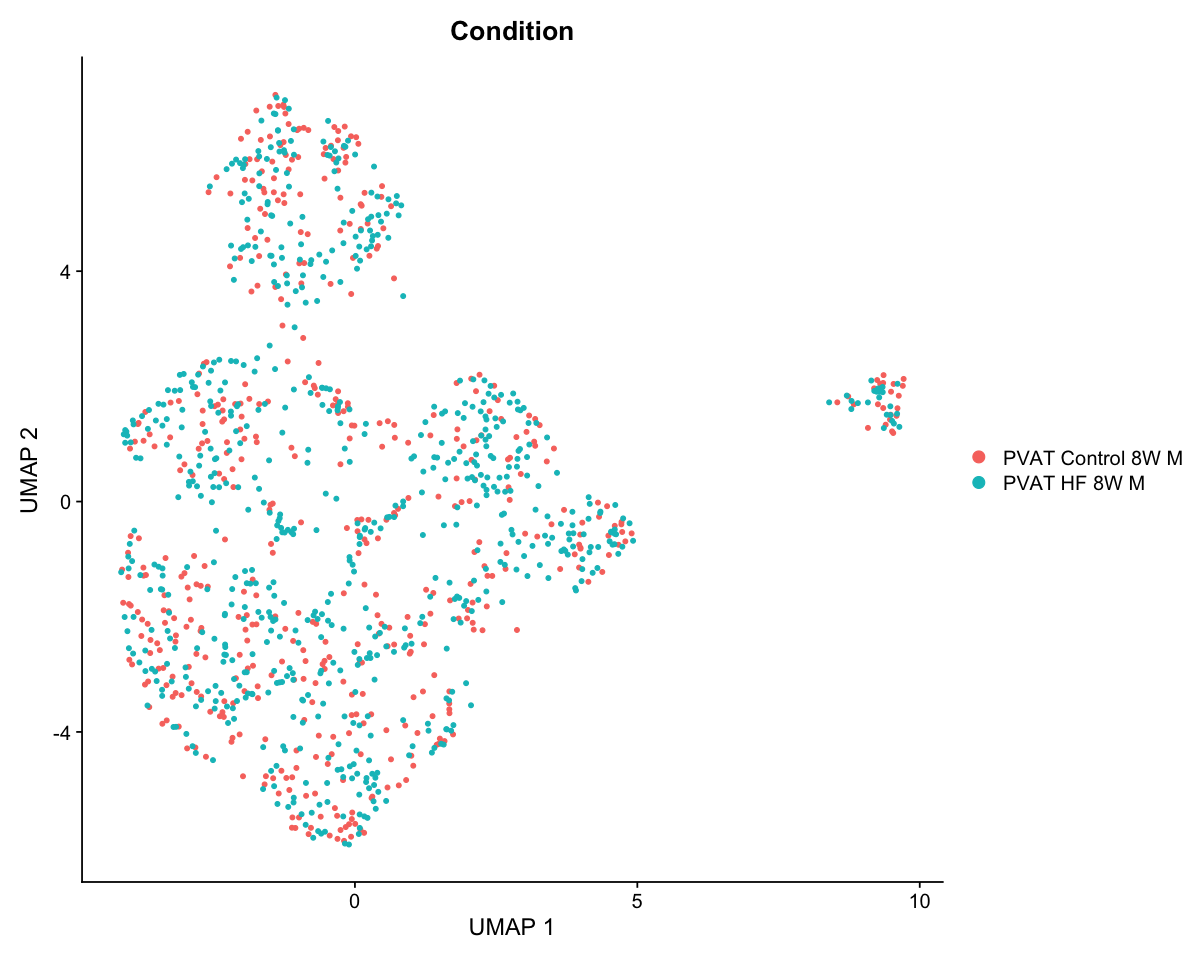

In [42]:

voi.data$Condition <- factor(voi.data$Condition, 
                             levels = c("taPVAT_Control_8W_M", "taPVAT_HF_8W_M"), 
                             labels = c("PVAT Control 8W M", "PVAT HF 8W M"))

plot <- DimPlot(voi.data,group.by = 'Condition') + labs(x = "UMAP 1", y = "UMAP 2")

plot 

ggsave("Fibroblasts-to-Adipocytes Gnas-Gcgr UMAP by Condition.pdf", plot = plot, width = 10, height = 8, dpi = 600)

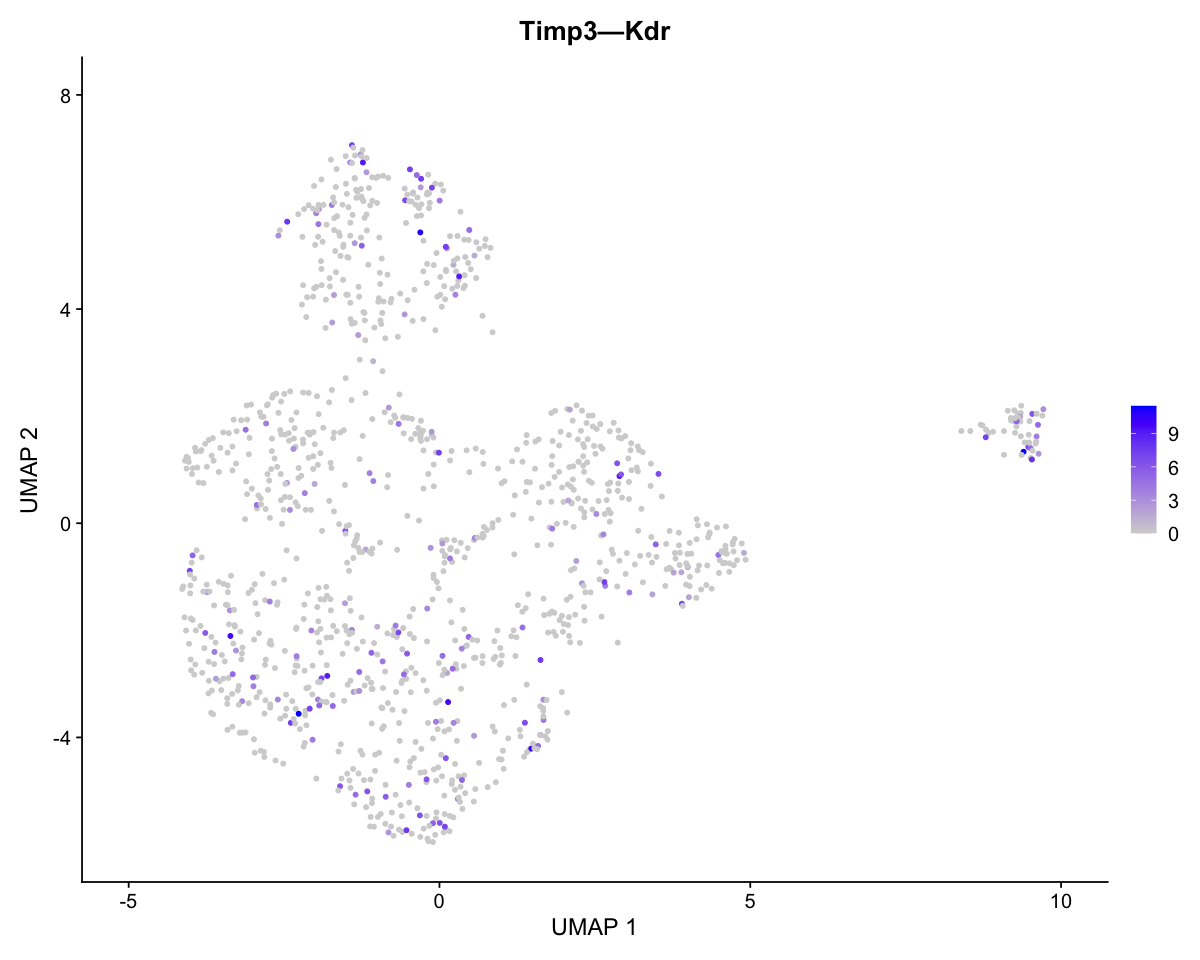

In [43]:
plot <- FeaturePlot(voi.data,
            features = c('Timp3—Kdr'),max.cutoff = 150) + labs(x = "UMAP 1", y = "UMAP 2")
plot 
ggsave("Fibroblasts-to-Adipocytes Timp3—Kdr UMAP.pdf", plot = plot, width = 10, height = 8, dpi = 600)

In [44]:
voi.data <- JoinLayers(object = voi.data, assay = "CellToCell", layers = c("data", "scale.data"))

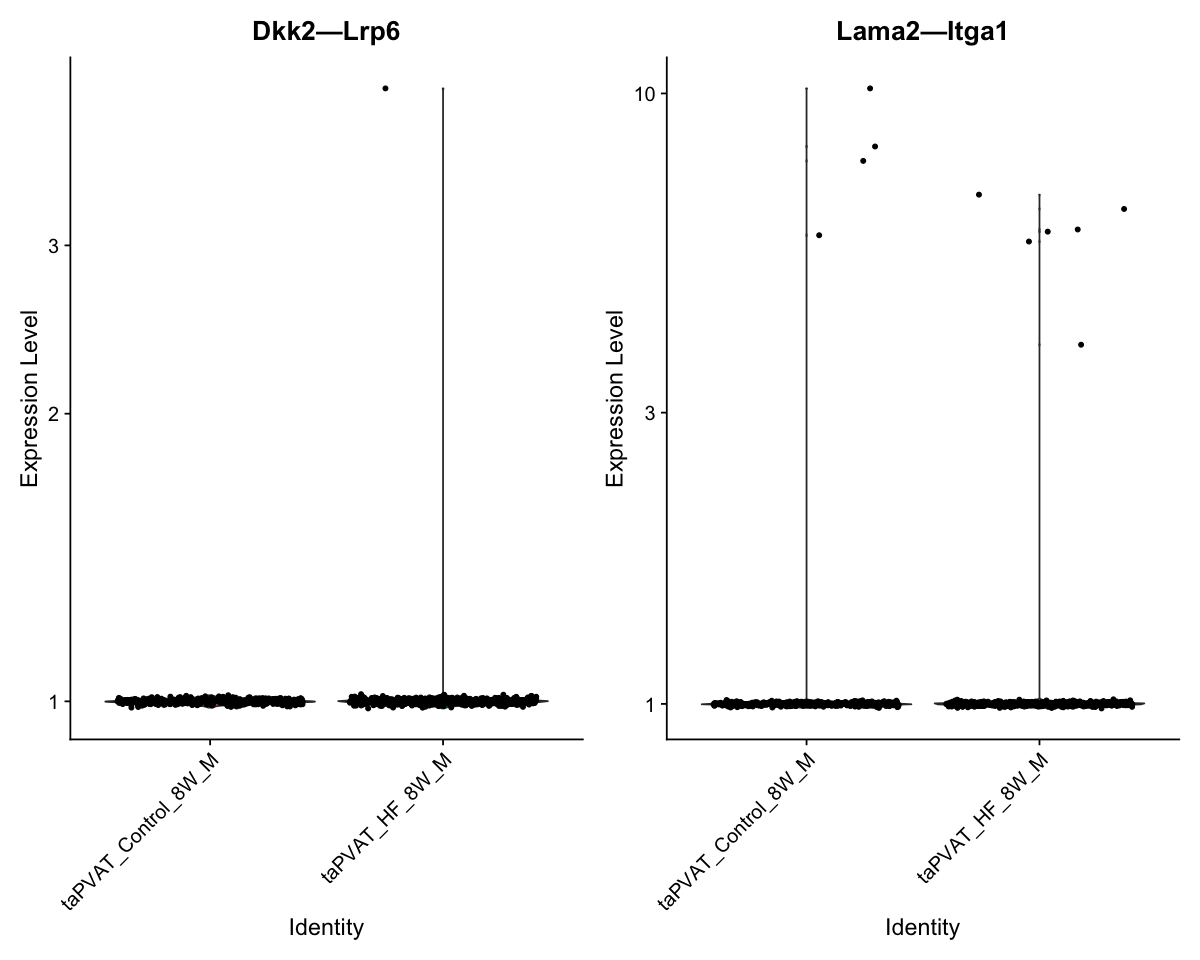

In [45]:
VlnPlot(voi.data,
            features = c('Dkk2—Lrp6','Lama2—Itga1'),log = T,group.by = 'Condition')

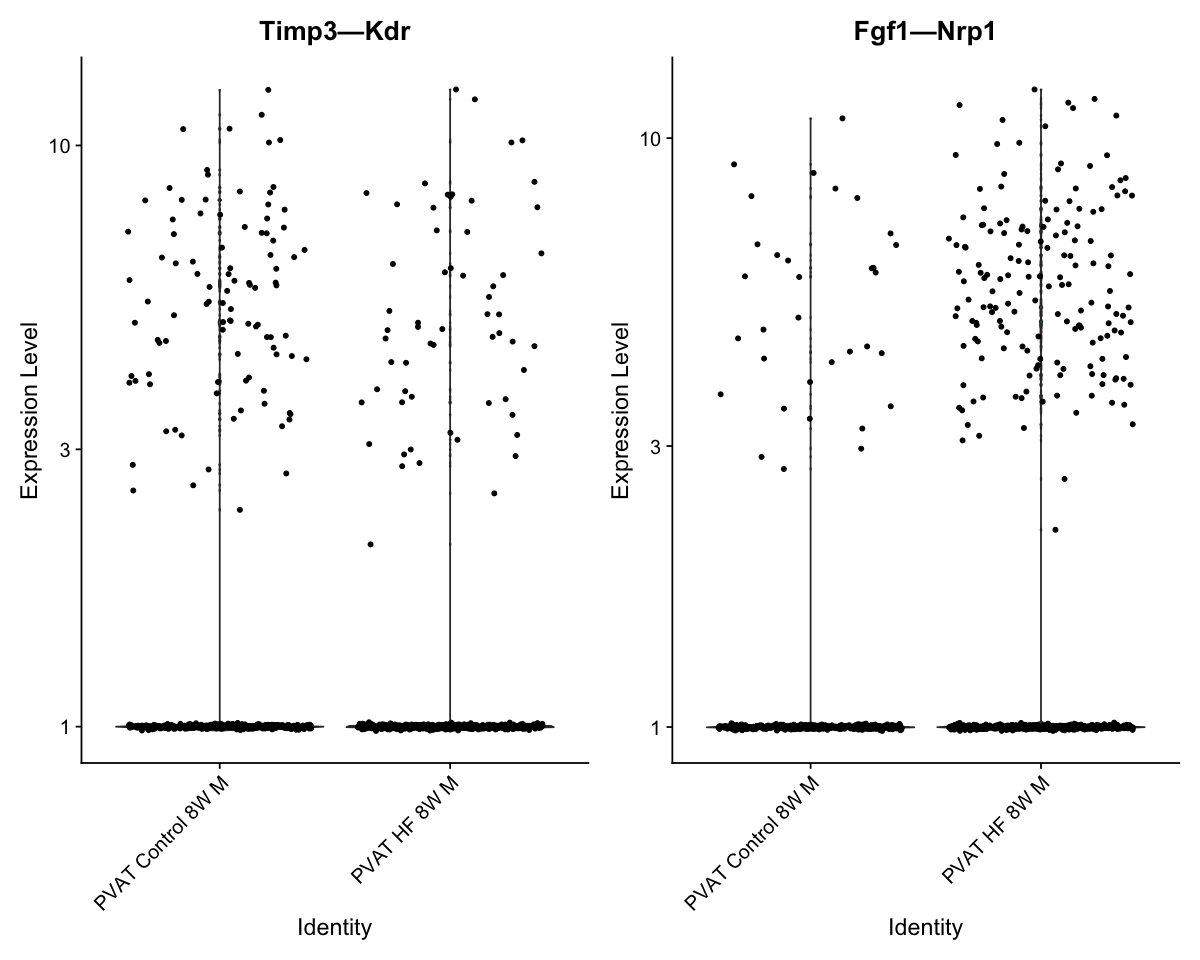

In [53]:




plot <- VlnPlot(voi.data,
        features = c('Timp3—Kdr', 'Fgf1—Nrp1'), log = TRUE, group.by = 'Condition')


plot

ggsave("Fibroblasts-to-Adipocytes Expression of Ligand-Receptor Pairs (Gnas—Gcgr, Plau—Lrp1) in 8-Week Male PVAT Control.pdf", plot = plot, width = 10, height = 8, dpi = 600)

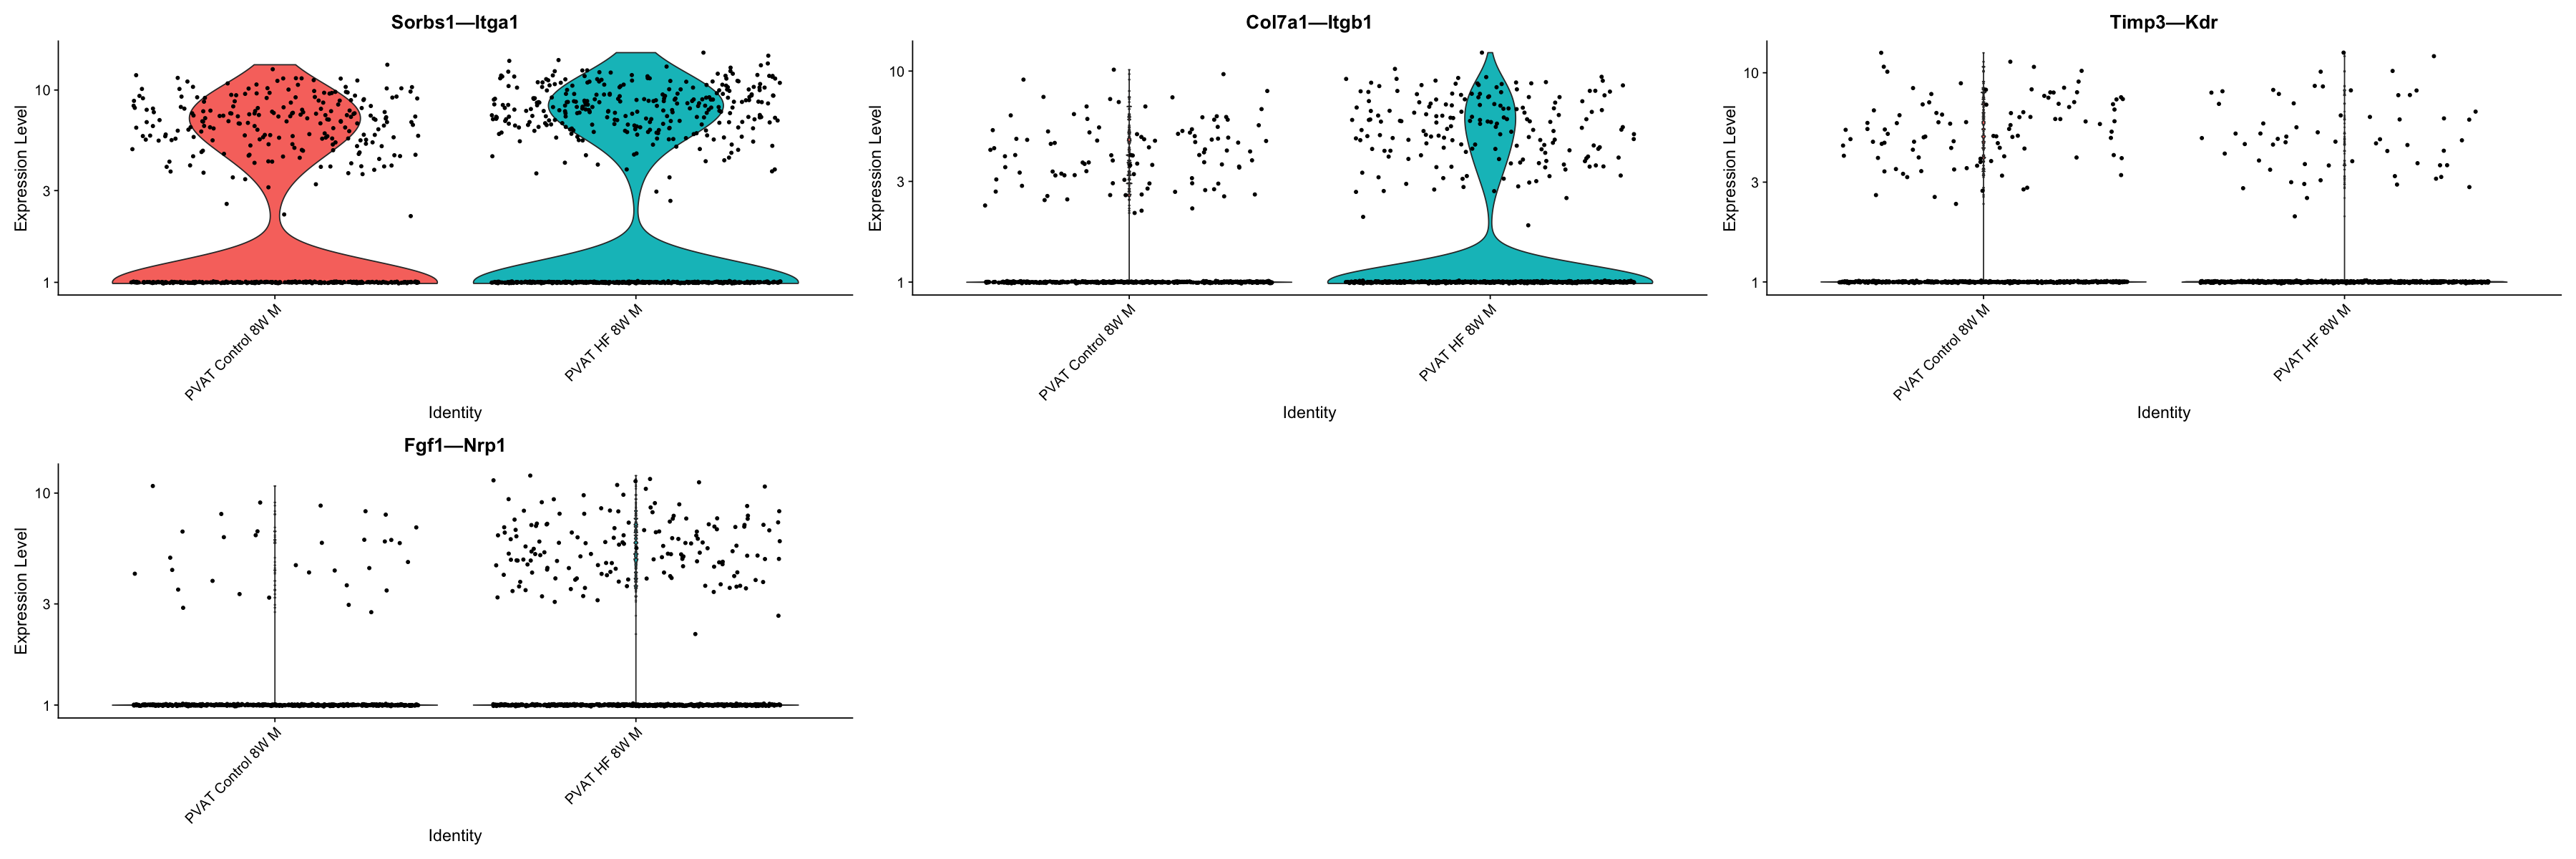

In [71]:
options(repr.plot.width=30, repr.plot.height=10)

plot <- VlnPlot(voi.data,
        features = c('Sorbs1—Itga1', 'Col7a1—Itgb1', 'Timp3—Kdr', 'Fgf1—Nrp1'), log = TRUE, group.by = 'Condition')
plot



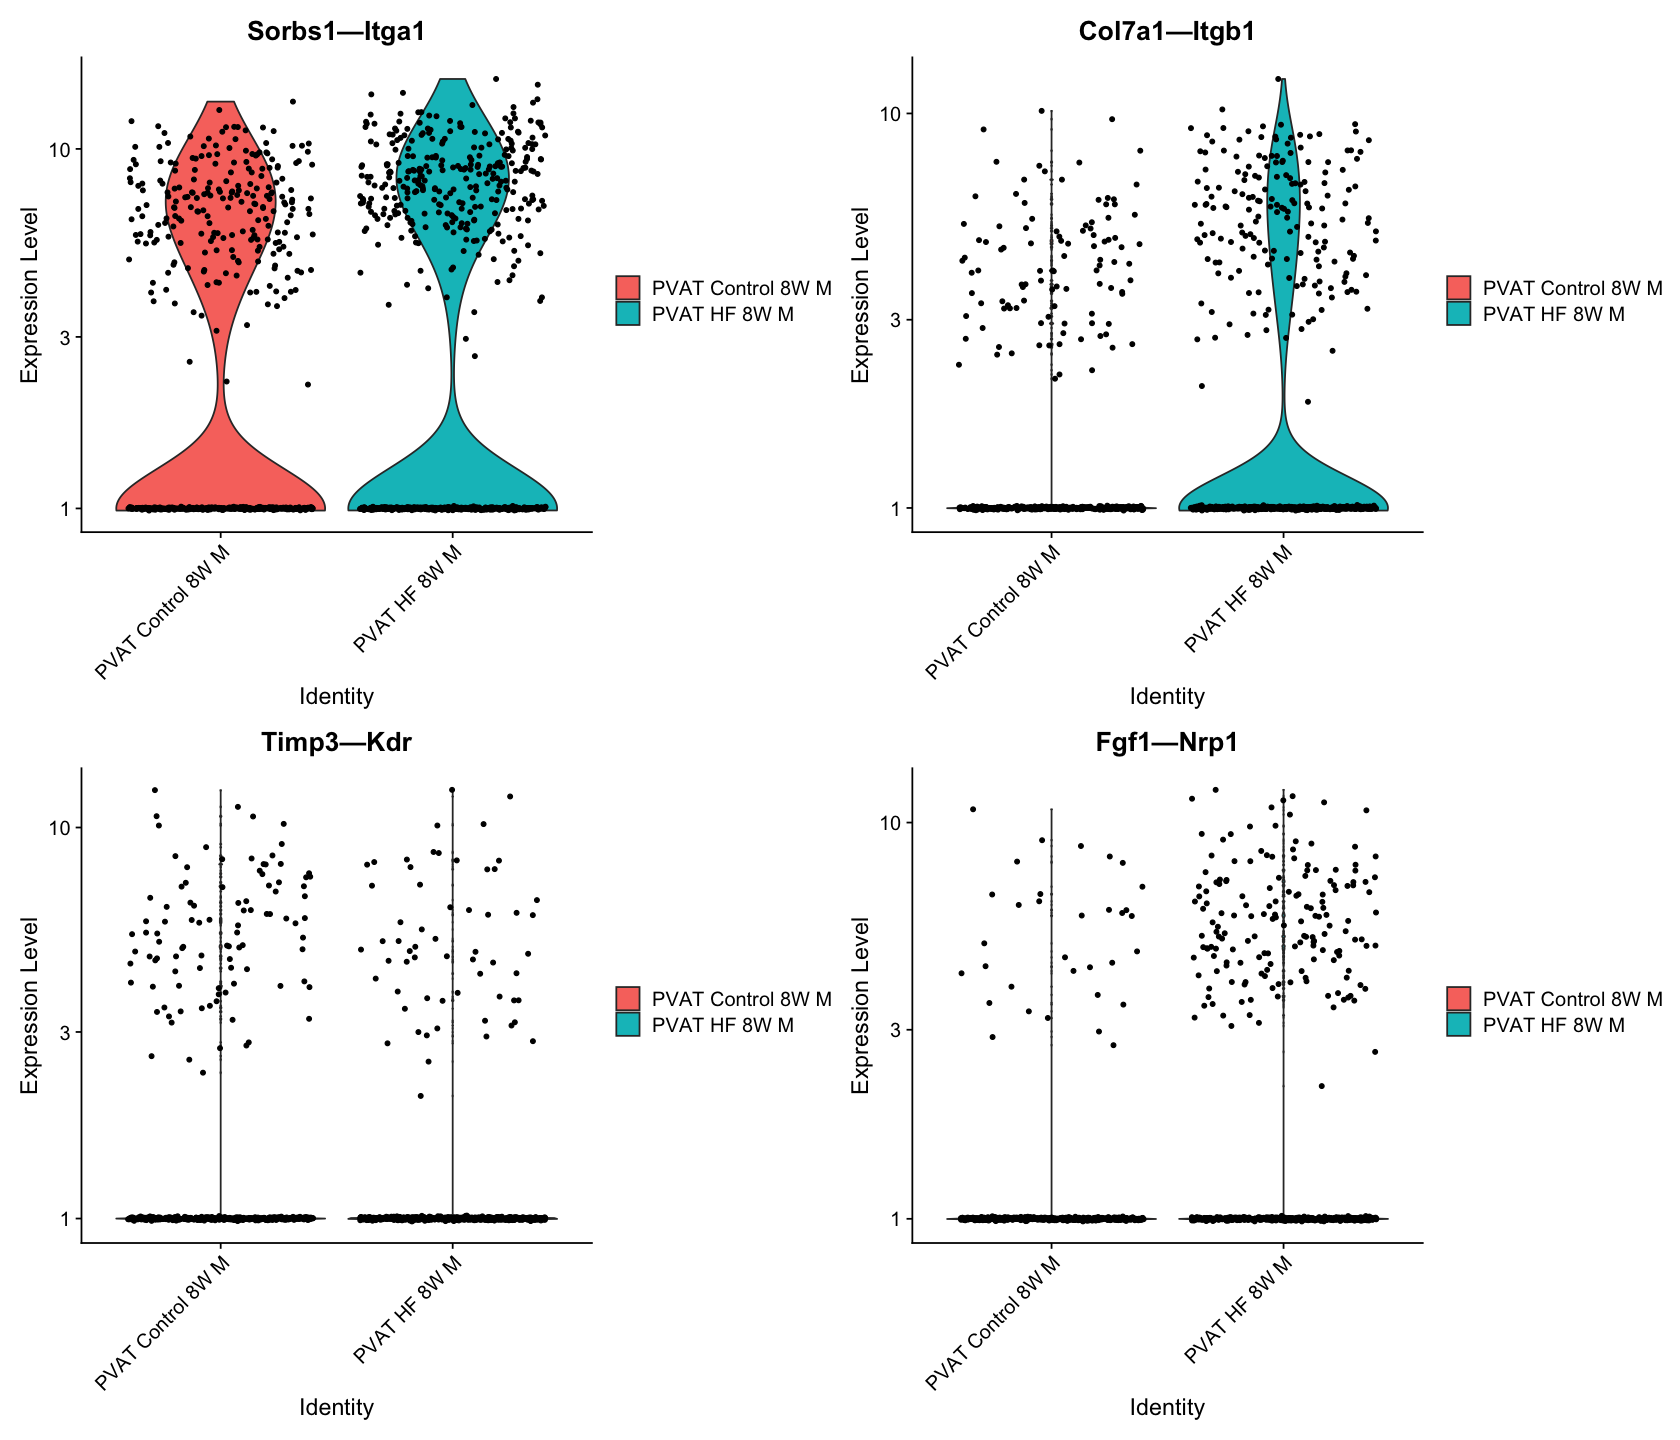

In [78]:
options(repr.plot.width=14, repr.plot.height=12)

plot1 <- VlnPlot(voi.data, features = 'Sorbs1—Itga1', log = TRUE, group.by = 'Condition')
plot2 <- VlnPlot(voi.data, features = 'Col7a1—Itgb1', log = TRUE, group.by = 'Condition')
plot3 <- VlnPlot(voi.data, features = 'Timp3—Kdr', log = TRUE, group.by = 'Condition')
plot4 <- VlnPlot(voi.data, features = 'Fgf1—Nrp1', log = TRUE, group.by = 'Condition')
plot <- (plot1 | plot2) / (plot3 | plot4)
plot
ggsave("Adipocytes to Endothelial Expression of Ligand-Receptor Pairs ('Sorbs1—Itga1', 'Col7a1—Itgb1', 'Timp3—Kdr', 'Fgf1—Nrp1') in 8-Week Male PVAT Control.pdf", plot = plot, width = 14, height = 12, dpi = 600)
ggsave("Adipocytes to Endothelial Expression of Ligand-Receptor Pairs ('Sorbs1—Itga1', 'Col7a1—Itgb1', 'Timp3—Kdr', 'Fgf1—Nrp1') in 8-Week Male PVAT Control.jpg", plot = plot, width = 14, height = 12, dpi = 600)


In [61]:
rownames(voi.data@assays$CellToCell@features)

[1] "Adam10—Axl"        "Adam10—Epha3"      "Adam12—Itga9"     
  [4] "Adam12—Itgb1"      "Adam12—Sdc4"       "Adam15—Itga5"     
  [7] "Adam15—Itga9"      "Adam15—Itgav"      "Adam15—Itgb1"     
 [10] "Adam15—Itgb3"      "Adam17—Erbb4"      "Adam17—Itga5"     
 [13] "Adam17—Itgb1"      "Adam17—Notch1"     "Adam23—Itga5"     
 [16] "Adam23—Itgb3"      "Adam28—Itga4"      "Adam9—Itga3"      
 [19] "Adam9—Itga6"       "Adam9—Itgav"       "Adam9—Itgb1"      
 [22] "Adam9—Itgb5"       "Adipoq—Adipor1"    "Adipoq—Adipor2"   
 [25] "Adm—Calcrl"        "Angpt1—Itga5"      "Angpt1—Itgb1"     
 [28] "Angpt1—Tek"        "Angpt1—Tie1"       "Angpt2—Tek"       
 [31] "Angpt2—Tie1"       "Angpt4—Tek"        "Angpt4—Tie1"      
 [34] "Angptl1—Tek"       "Angptl2—Tie1"      "Angptl4—Tie1"     
 [37] "Anxa1—Dysf"        "Anxa1—Egfr"        "Apoe—Ldlr"        
 [40] "Apoe—Lrp1"         "Apoe—Lrp5"         "Apoe—Scarb1"      
 [43] "Apoe—Sorl1"        "Apoe—Vldlr"        "App—Cav1"         
 [46] "App—Cd74"          "App—Lrp1"          "App—Ncstn"        
 [49] "App—Slc45a3"       "App—Tnfrsf21"      "B2m—Cd247"        
 [52] "B2m—Tfrc"          "Bgn—Ly96"          "Bgn—Tlr4"         
 [55] "Bmp4—Acvr1"        "Bmp4—Acvr2a"       "Bmp4—Acvr2b"      
 [58] "Bmp4—Bmpr1a"       "Bmp4—Bmpr1b"       "Bmp4—Bmpr2"       
 [61] "Bmp5—Acvr1"        "Bmp5—Acvr2a"       "Bmp5—Acvr2b"      
 [64] "Bmp5—Bmpr1a"       "Bmp5—Bmpr1b"       "Bmp5—Bmpr2"       
 [67] "Bmp6—Acvr1"        "Bmp6—Acvr2a"       "Bmp6—Acvr2b"      
 [70] "Bmp6—Bmpr1a"       "Bmp6—Bmpr1b"       "Bmp6—Bmpr2"       
 [73] "C4b—Cd46"          "Calm1—Abca1"       "Calm1—Adcyap1r1"  
 [76] "Calm1—Cacna1c"     "Calm1—Egfr"        "Calm1—Fas"        
 [79] "Calm1—Glp2r"       "Calm1—Insr"        "Calm1—Kcnn4"      
 [82] "Calm1—Kcnq1"       "Calm1—Kcnq5"       "Calm1—Mylk"       
 [85] "Calm1—Pde1a"       "Calm1—Pde1b"       "Calm1—Pde1c"      
 [88] "Calm1—Ptpra"       "Calm1—Sctr"        "Calm1—Sell"       
 [91] "Calm1—Trpc3"       "Calm2—Abca1"       "Calm2—Egfr"       
 [94] "Calm2—Insr"        "Calm2—Kcnq1"       "Calm2—Kcnq5"      
 [97] "Calm2—Mylk"        "Calm2—Pde1a"       "Calm2—Pde1b"      
[100] "Calm2—Pde1c"       "Calm2—Sell"        "Calr—Itga3"       
[103] "Calr—Itgav"        "Calr—Lrp1"         "Calr—Scarf1"      
[106] "Calr—Tshr"         "Cd34—Sell"         "Cfh—Itgam"        
[109] "Cfh—Sell"          "Cgn—F11r"          "Cgn—Tgfbr1"       
[112] "Cgn—Tgfbr2"        "Clcf1—Cntfr"       "Clcf1—Crlf1"      
[115] "Clcf1—Il6st"       "Clcf1—Lifr"        "Cntf—Cntfr"       
[118] "Cntf—Il6st"        "Cntf—Lifr"         "Cntn4—Ptprg"      
[121] "Col14a1—Cd44"      "Col18a1—Gpc4"      "Col18a1—Itga5"    
[124] "Col18a1—Itgb1"     "Col18a1—Kdr"       "Col1a1—Cd44"      
[127] "Col1a1—Cd93"       "Col1a1—Ddr1"       "Col1a1—Ddr2"      
[130] "Col1a1—Flt4"       "Col1a1—Itga1"      "Col1a1—Itga11"    
[133] "Col1a1—Itga5"      "Col1a1—Itgav"      "Col1a1—Itgb1"     
[136] "Col1a2—Cd44"       "Col1a2—Cd93"       "Col1a2—Flt4"      
[139] "Col1a2—Itga1"      "Col1a2—Itga11"     "Col1a2—Itgav"     
[142] "Col1a2—Itgb1"      "Col1a2—Itgb3"      "Col3a1—Ddr1"      
[145] "Col3a1—Ddr2"       "Col3a1—Itgb1"      "Col4a1—Cd47"      
[148] "Col4a1—Cd93"       "Col4a1—Itga1"      "Col4a1—Itgav"     
[151] "Col4a1—Itgb1"      "Col4a1—Itgb8"      "Col4a2—Cd93"      
[154] "Col4a3—Cd47"       "Col4a3—Cd93"       "Col4a3—Itga1"     
[157] "Col4a3—Itgav"      "Col4a3—Itgb1"      "Col4a4—Cd47"      
[160] "Col4a4—Cd93"       "Col4a4—Itga1"      "Col4a4—Itgav"     
[163] "Col4a4—Itgb1"      "Col4a5—Cd47"       "Col4a5—Cd93"      
[166] "Col4a5—Itga1"      "Col4a5—Itgav"      "Col4a5—Itgb1"     
[169] "Col4a6—Cd47"       "Col4a6—Cd93"       "Col4a6—Itga1"     
[172] "Col4a6—Itgav"      "Col4a6—Itgb1"      "Col5a1—Itga1"     
[175] "Col5a1—Itgb1"      "Col5a1—Sdc3"       "Col5a2—Ddr1"      
[178] "Col5a2—Itga1"      "Col5a2—Itgb1"      "Col5a3—Sdc3"      
[181] "Col6a1—Itga1"      "Col6a1—Itga6"  